<a href="https://colab.research.google.com/github/rebecachuffi/projetos/blob/main/Cassi_RebecaChuffi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIENTISTA DE DADOS JÚNIOR (INCLUSIVA PARA PERFIS DA DIVERSIDADE)

**Nome:** Rebeca Chuffi Saccochi

**Data:** 27/07/2025


## Introdução

Vamos utilizar o *dataset* disponibilizado pela Cassi. O objetivo é identificar os fatores relacionados ao cancelamento de beneficiários de um plano de saúde e gerar insights que ajudem a reduzir o *churn* - taxa de rotatividade, ou seja, perda de clientes de uma empresa durante um período específico.

**Hipóteses:**

*   Quais estados tem a maior evasão
*   Quais faixas de renda tem as maiores evasões
*   Quais faixas etárias tem as maiores evasões

##Dataset

No dataset disponibilizado, temos os seguintes atributos:

*  ID_CLIENTE: identificação única do cliente (chave primária)
*  CANCELADO: Verifica se o plano foi cancelado ou não.
*  TITULARIDADE: se é titular ou dependente do plano
*  FAIXA_RENDA: baixa, média ou alta renda
*  TEMPO_DE_PLANO_MESES:
*  IDADENAADESÃO: qual idade na época da adesão
*  TEMPO_DE_PLANO_MESES: há quantos meses o tem o plano
*  SEXO: sexo
*  UF: localidade
*  INADIMPLENTE: se está inadiplente (sim ou não)
*  QTD_CONSULTAS_12M: quantas consultas nos últimos 12 meses
*  QTD_INTERNACOES_12M: quantas internações nos últimos 12 meses
*  VALOR_MENSALIDADE: valor da mensalidade paga

###Bibliotecas

In [469]:
!pip install rich
!pip install iso3166
!pip install diptest

In [470]:
#Manipulação de data frames
import pandas as pd
import missingno as ms # para tratamento de missings

#manipulação numérica
import numpy as np

#construção de gráficos
import matplotlib.pyplot as plt

#biblioteca de países
import pycountry

#exibição de dados no jupyter notebook
from IPython.display import display

#graficos
import seaborn as sns

#estatística
import diptest
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#pré-processamento e modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


from rich.console import Console
from rich.panel import Panel
console = Console()

from iso3166 import countries




###Carga de datasets

In [471]:
#função baixar arquivos git:

def baixar_arquivo_git(url, enc):  #todos em string
    if url.endswith('.csv'):
        df = pd.read_csv(url, encoding=enc)
    elif url.endswith('.xlsx'):
        df = pd.read_excel(url)
    else:
        raise ValueError("Formato de arquivo não suportado")


    print(f'Arquivo {url.split("/")[-1]} carregado com sucesso!')

    return df

In [472]:
#baixando dataset

cassi = baixar_arquivo_git('https://raw.githubusercontent.com/rebecachuffi/projetos/main/plano.xlsx', None)
cassi

Arquivo plano.xlsx carregado com sucesso!


,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE
0,53100,TITULAR,NÃO,Média renda,39,302,F,RJ,NÃO,12,1,1030.0
1,140400,TITULAR,NÃO,Média renda,24,307,F,BA,NÃO,4,0,720.0
2,105059,TITULAR,NÃO,Média renda,1,295,M,MG,NÃO,6,7,NaN
3,82963,TITULAR,NÃO,Média renda,36,294,M,RJ,NÃO,21,1,1030.0
4,97768,TITULAR,SIM,Baixa renda,20,259,F,RN,NÃO,30,0,550.0
...,...,...,...,...,...,...,...,...,...,...,...,...
101058,102774,TITULAR,SIM,Baixa renda,78,190,F,RN,NÃO,10,2,1870.0
101059,91023,TITULAR,SIM,Baixa renda,14,231,M,MA,SIM,32,1,NaN
101060,64406,TITULAR,SIM,Baixa renda,14,162,F,SP,SIM,3,1,550.0
101061,137116,TITULAR,SIM,Alta renda,75,142,F,RJ,NÃO,5,1,1870.0


## Exploração e Limpeza de dados

In [473]:
#Tipos de dados

cassi.dtypes

,0
ID_CLIENTE,int64
TITULARIDADE,object
CANCELADO,object
FAIXA_RENDA,object
IDADENAADESÃO,int64
TEMPO_DE_PLANO_MESES,int64
SEXO,object
UF,object
INADIMPLENTE,object
QTD_CONSULTAS_12M,int64


In [474]:
#shape do dataframe original
cassi.shape

(101063, 12)

###ID_CLIENTE



Para o atributo `ID_CLIENTE`, vamos primeiramente verificar se não há nenhuma duplicata (visto que é uma chave primária) que pode ter sido resultado de algum erro de sistema ou de tabelamento:

In [475]:
duplicados_ID = cassi['ID_CLIENTE'].duplicated().any()
duplicados_ID

np.True_

Como `duplicados_ID` é verdadeiros, temos clientes com o mesmo ID na lista. Vamos verificar quais são eles:

In [476]:
linhas_duplicadas_ID = cassi[cassi['ID_CLIENTE'].duplicated(keep = False)]
linhas_duplicadas_ID

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE
0,53100,TITULAR,NÃO,Média renda,39,302,F,RJ,NÃO,12,1,1030.0
12,128020,TITULAR,SIM,Baixa renda,1,297,F,RJ,NÃO,28,1,550.0
45,141593,TITULAR,SIM,Baixa renda,30,227,F,SE,NÃO,11,2,720.0
70,144143,TITULAR,NÃO,Média renda,0,309,M,RJ,NÃO,3,1,NaN
76,89760,TITULAR,NÃO,Alta renda,14,308,NaN,RJ,NÃO,14,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
100997,57059,TITULAR,NÃO,Média renda,14,309,F,DF,NÃO,10,0,NaN
101007,144223,TITULAR,SIM,Baixa renda,0,266,M,CE,NÃO,12,0,NaN
101053,52818,TITULAR,SIM,Alta renda,29,298,M,RJ,NÃO,1,3,NaN
101056,88896,TITULAR,SIM,Baixa renda,71,306,F,BA,NÃO,12,1,1870.0


Como podemos ver acima, temos várias linhas duplicadas. Vamos deletar as linhas excedentes (mantendo apenas a primeira ocorrencia) através da criação da seguinte função:

In [477]:
def remover_duplicatas(df: pd.DataFrame, atributo: str)-> pd.DataFrame:
    df_sem_duplicatas = df.drop_duplicates(subset = atributo, keep = 'first')
    return df_sem_duplicatas

In [478]:
#fazendo uma cópia do dataset original
cassi_original = cassi.copy()

In [479]:
#mantendo apenas a primeira aparição de cada ID
cassi = remover_duplicatas(cassi, 'ID_CLIENTE')

In [480]:
#verificando se funcionou
linhas_duplicadas_ID = cassi[cassi['ID_CLIENTE'].duplicated(keep = False)]
linhas_duplicadas_ID

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE


Note que agora não temos nenhuma linha com `ID_CLIENTE` duplicado.

In [481]:
cassi.shape[0]

94498

Inicialmente tínhamos 101.063 instâncias, logo 6565 linhas foram eliminadas nessa etapa.

###Valores Nulos ou Faltantes

Nesta etapa vamos criar uma função que nos retorna quantos valores faltantes temos em cada coluna e quais são eles:

In [482]:
def valores_faltantes(col,df):
    if df[col].isnull().sum() > 0:
      print(f'✔️ Campos vazios em "{col}": {df[col].isnull().sum()}') #emote de "check" para ajudar na visualização rápida dos dados para análise
      print(f'Linhas com a coluna "{col}" vazias:\n')
      print(df[df[col].isnull()])
      print()
      return True
    else:
      print(f'❌ Nenhuma célula na coluna "{col}" é vazia.\n')
      return False

In [483]:
#teste da função
valores_faltantes('ID_CLIENTE', cassi)
valores_faltantes('VALOR_MENSALIDADE', cassi)

❌ Nenhuma célula na coluna "ID_CLIENTE" é vazia.

✔️ Campos vazios em "VALOR_MENSALIDADE": 34779
Linhas com a coluna "VALOR_MENSALIDADE" vazias:

        ID_CLIENTE TITULARIDADE CANCELADO  FAIXA_RENDA  IDADENAADESÃO  \
2           105059      TITULAR       NÃO  Média renda              1   
5            91139      TITULAR       SIM  Baixa renda              3   
6            88445      TITULAR       SIM  Baixa renda             66   
7            52541      TITULAR       NÃO  Média renda             39   
8            58821      TITULAR       NÃO  Baixa renda             35   
...            ...          ...       ...          ...            ...   
101049      100441      TITULAR       SIM  Baixa renda             25   
101052       87730      TITULAR       SIM  Baixa renda              5   
101054       59403      TITULAR       SIM  Baixa renda             19   
101055       75897      TITULAR       NÃO  Média renda             41   
101057      101190      TITULAR       SIM  Baixa re

True

In [484]:
def quaisquer_valores_faltantes(df): #colunas com valores faltantes (e quais são elas)
    colunas_faltantes = list()
    linhas_faltantes = set()
    for col in df.columns:
      if valores_faltantes(col,df):
        colunas_faltantes.append(col)
        linhas_faltantes.update(df[df[col].isnull()].index)

    if len(colunas_faltantes) > 0:
      return True
    else:
      return False


In [485]:
#Verificando no nosso dataset os valores faltantes:

quaisquer_valores_faltantes(cassi)

❌ Nenhuma célula na coluna "ID_CLIENTE" é vazia.

❌ Nenhuma célula na coluna "TITULARIDADE" é vazia.

❌ Nenhuma célula na coluna "CANCELADO" é vazia.

❌ Nenhuma célula na coluna "FAIXA_RENDA" é vazia.

❌ Nenhuma célula na coluna "IDADENAADESÃO" é vazia.

❌ Nenhuma célula na coluna "TEMPO_DE_PLANO_MESES" é vazia.

✔️ Campos vazios em "SEXO": 1855
Linhas com a coluna "SEXO" vazias:

        ID_CLIENTE TITULARIDADE CANCELADO  FAIXA_RENDA  IDADENAADESÃO  \
25           92032      TITULAR       SIM  Baixa renda            220   
76           89760      TITULAR       NÃO   Alta renda             14   
151         140521      TITULAR       NÃO  Baixa renda             21   
194          79653      TITULAR       SIM  Baixa renda             19   
393          97716      TITULAR       SIM  Baixa renda             78   
...            ...          ...       ...          ...            ...   
100884       62471      TITULAR       NÃO  Média renda              2   
100973       64238      TITULAR 

True

Note que temos:


*  **ID_CLIENTE**: Sem valores faltantes
*  **CANCELADO:** Sem valores faltantes
*  **TITULARIDADE:** Sem valores faltantes
*  **FAIXA_RENDA:** Sem valores faltantes
*  **TEMPO_DE_PLANO_MESES:** Sem valores faltantes
*  **IDADENAADESÃO:** Sem valores faltantes
*  **TEMPO_DE_PLANO_MESES:** Sem valores faltantes
*  **SEXO:** 1855 linhas com valores faltantes
*  **UF:** 1912 linhas com valores faltantes
*  **INADIMPLENTE:**Sem valores faltantes
*  **QTD_CONSULTAS_12M:** Sem valores faltantes
*  **QTD_INTERNACOES_12M:** Sem valores faltantes
*  **VALOR_MENSALIDADE:** 34779 linhas com valores faltantes


####Tratando valores faltantes

Pela análise anterior, precisamos tratas os seguintes subconjuntos de dados:

*  **SEXO:** 1855 linhas com valores faltantes
*  **UF:** 1912 linhas com valores faltantes
*  **VALOR_MENSALIDADE:** 34779 linhas com valores faltantes





#####Sexo


Para esse atributo, temos a opção de preencher os valores faltantes com a moda ou remover as linhas com valores faltantes. Vamos analisar primeiro qual a porcentagem de dados faltantes para o atributo SEXO:

Quantidade total de linhas do dataset: $94.498$

Quantidade de linhas con valores faltantes em `SEXO`: $1.855 $

Porcentagem de aproximadamente $1.96\%$ de dados faltantes.

É uma porcentagem relativamente baixa, mas precisamos entender se, caso a gente preencha com a moda, se a distribuição ficará balanceada ou tendenciosa.

In [486]:
#distribuição de SEXO:
distribuicao_sexo = cassi['SEXO'].value_counts()
print(distribuicao_sexo)

SEXO
F    52830
M    39813
Name: count, dtype: int64


In [487]:
cassi.shape[0]

94498

Como a dristibuição do atributo está relativamente balanceada, caso a gente substitua os valores faltantes pela moda (F), adicionaremos uma diferença maior entre as classes:



In [488]:
#Caso a gente SUBSTITUA os valores faltantes pela moda (F):

feminino_moda = 1855 + 52830
masculino = 39813
porcentagem_feminino_moda = feminino_moda / 94498 * 100

print(f'Porcentagem feminino novo: {porcentagem_feminino_moda:.2f}%')


Porcentagem feminino novo: 57.87%


In [489]:
#Caso a gente DELETE os valores faltantes pela moda (F):
feminino_delete = 52830
masculino = 39813
porcentagem_feminino_delete = feminino_delete / 92643 * 100

print(f'Porcentagem feminino novo: {porcentagem_feminino_delete:.2f}%')

Porcentagem feminino novo: 57.03%


Como a diferença é pequena entre os dois possíveis casos, para não criar possíveis outliers nas análises por "SEXO", vamos optar por deletar as linhas com dados faltantes.


In [490]:
cassi_sexo_original = cassi.copy() #criando uma cópia caso a gente queira acessar os dados com essa etapa não modificada

In [491]:
#deletanto as colunas com SEXO faltantes
cassi = cassi.dropna(subset = ['SEXO'])
len(cassi)

92643

#####UF

Agora vamos verificar os dados faltantes na coluna `UF`


In [492]:
#Verificando no nosso dataset os valores faltantes:

quaisquer_valores_faltantes(cassi) #nota que SEXO não tem mais dados faltantes

❌ Nenhuma célula na coluna "ID_CLIENTE" é vazia.

❌ Nenhuma célula na coluna "TITULARIDADE" é vazia.

❌ Nenhuma célula na coluna "CANCELADO" é vazia.

❌ Nenhuma célula na coluna "FAIXA_RENDA" é vazia.

❌ Nenhuma célula na coluna "IDADENAADESÃO" é vazia.

❌ Nenhuma célula na coluna "TEMPO_DE_PLANO_MESES" é vazia.

❌ Nenhuma célula na coluna "SEXO" é vazia.

✔️ Campos vazios em "UF": 1878
Linhas com a coluna "UF" vazias:

        ID_CLIENTE TITULARIDADE CANCELADO  FAIXA_RENDA  IDADENAADESÃO  \
84          106239      TITULAR       SIM  Baixa renda             28   
114          61564      TITULAR       NÃO  Média renda            234   
201         129060      TITULAR       NÃO  Média renda             43   
274          62858      TITULAR       SIM  Baixa renda              0   
338          64904      TITULAR       NÃO  Baixa renda             38   
...            ...          ...       ...          ...            ...   
100938      127548      TITULAR       SIM  Baixa renda           

True

Rodamos a função `quaisquer_valores_faltantes(cassi)` novamente, pois ao excluir linhas com dados faltantes no atributo "SEXO", é possível que já tenhamos excluído algumas linhas com dados faltantes em "UF", que foi o que aconteceu (pois temos menos linhas com dados faltantes, comparados à primeira análise):

*  **UF:** $1878$ linhas com valores faltantes

In [493]:
#distribuição de UF:
distribuicao_uf = cassi['UF'].value_counts()
print(distribuicao_uf)

UF
SP    14876
RJ    13810
BA    11660
MG     8866
DF     6153
MA     4708
PE     4625
RS     3820
PR     2664
SE     2476
AL     2293
RN     2256
ES     1768
CE     1683
SC     1635
GO     1474
PB     1436
PA     1311
MS      896
PI      776
MT      718
AM      317
TO      148
RO      136
AC      120
AP       85
RR       55
Name: count, dtype: int64


Note que, nesse caso, as classes estão desbalanceadas. Temos muito mais instâncias nos estados SP, RJ, BA e MG. Com isso, caso substituíssemos os valores pela moda (SP), ou mesmo RJ, estaríamos favorecendo ainda mais os estados mais representados no dataset. Com isso, vamos deletar as colunas com dados faltantes.  

In [494]:
#criando uma cópia
cassi_uf_original = cassi.copy()

In [495]:
cassi = cassi.dropna(subset = ['UF'])
len(cassi)

90765

#####VALOR_MENSALIDADE

In [496]:
#Verificando no nosso dataset os valores faltantes:

quaisquer_valores_faltantes(cassi) #nota que SEXO e UF não tem mais dados faltantes

❌ Nenhuma célula na coluna "ID_CLIENTE" é vazia.

❌ Nenhuma célula na coluna "TITULARIDADE" é vazia.

❌ Nenhuma célula na coluna "CANCELADO" é vazia.

❌ Nenhuma célula na coluna "FAIXA_RENDA" é vazia.

❌ Nenhuma célula na coluna "IDADENAADESÃO" é vazia.

❌ Nenhuma célula na coluna "TEMPO_DE_PLANO_MESES" é vazia.

❌ Nenhuma célula na coluna "SEXO" é vazia.

❌ Nenhuma célula na coluna "UF" é vazia.

❌ Nenhuma célula na coluna "INADIMPLENTE" é vazia.

❌ Nenhuma célula na coluna "QTD_CONSULTAS_12M" é vazia.

❌ Nenhuma célula na coluna "QTD_INTERNACOES_12M" é vazia.

✔️ Campos vazios em "VALOR_MENSALIDADE": 33390
Linhas com a coluna "VALOR_MENSALIDADE" vazias:

        ID_CLIENTE TITULARIDADE CANCELADO  FAIXA_RENDA  IDADENAADESÃO  \
2           105059      TITULAR       NÃO  Média renda              1   
5            91139      TITULAR       SIM  Baixa renda              3   
6            88445      TITULAR       SIM  Baixa renda             66   
7            52541      TITULAR       NÃO  

True

In [497]:
#distribuição de SEXO:
distribuicao_mensalidade = cassi['VALOR_MENSALIDADE'].value_counts()
print(distribuicao_mensalidade)

VALOR_MENSALIDADE
550.0     19659
1030.0    15629
720.0     10778
1360.0     6300
1870.0     5009
Name: count, dtype: int64


A análise acima mostra, em particular, que não há valores nulos para o atributo de mensalidade.

**VALOR_MENSALIDADE**:  33390 linhas com valores faltantes.

Note que nesse caso, não podemos excluir os valores faltantes (pois, caso o fizéssemos, excluiríamos aproximadamente $36.8\%$ dos dados, o que é uma perda de dados considerável), logo, vamos preencher os valores faltantes.

Nesse caso estamos falando de valor de mensalidade. Faz sentido imaginar que uma pessoa com uma renda baixa não pode ter o atributo de mensalidade preenchido com uma média mais alta do que se espera para essa faixa.

Além disso, temos apenas $5$ opções de mensalidades do dataser:

*   Mensalidade E = R\$550.0 - 19659 instâncias   
*   Mensalidade D = R\$720.0 - 10778 instâncias  
*   Mensalidade C = R\$1030.0 - 15629 instâncias
*   Mensalidade B = R\$1360.0 - 6300 instâncias
*   Mensalidade A = R\$1870.0 - 5009 instâncias

Vamos primeiramente analisar a distribuição do `VALOR_MENSALIDADE` de maneira geral:

/tmp/ipython-input-3086480270.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(contagem_baixa_renda.index)
/tmp/ipython-input-3086480270.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(contagem_media_renda.index)
/tmp/ipython-input-3086480270.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(contagem_alta_renda.index)


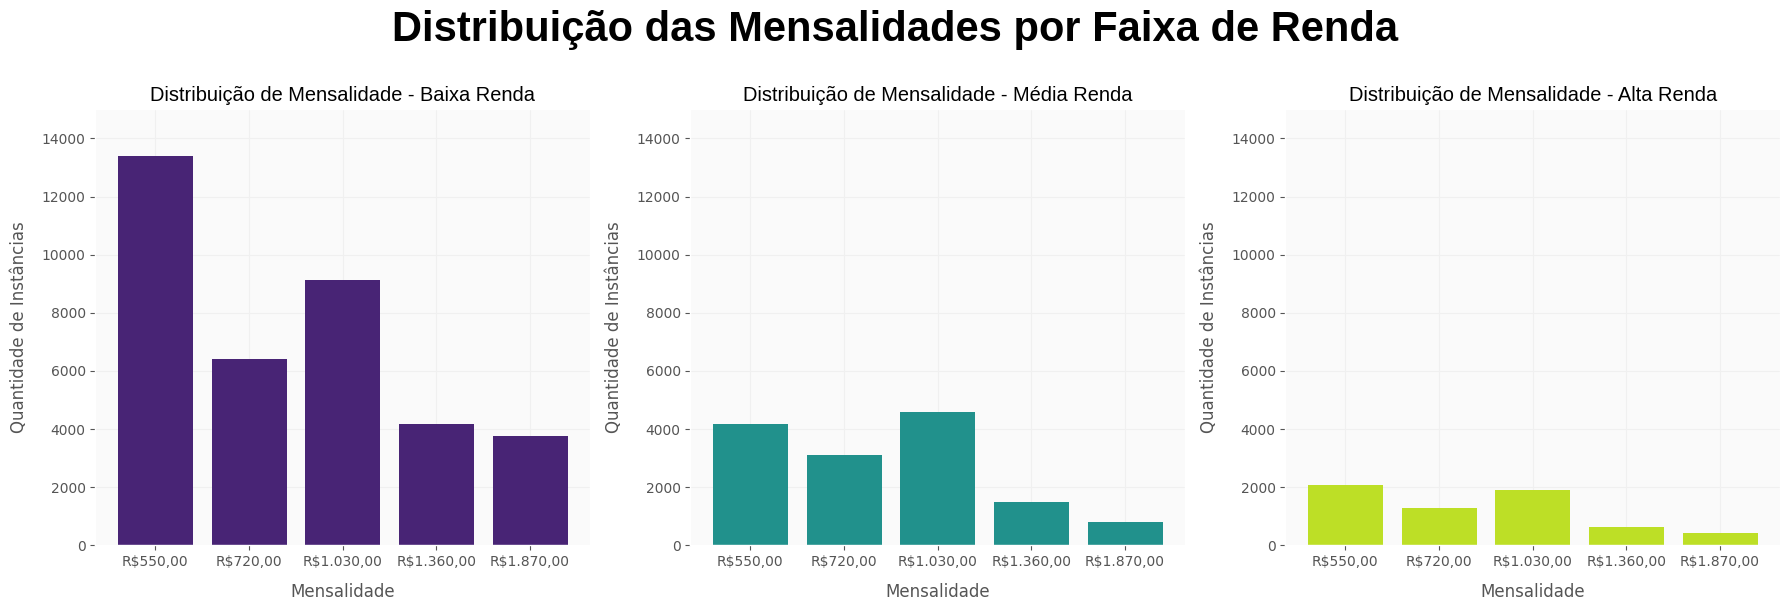

In [498]:
# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

# Definindo as 5 faixas de mensalidade como categorias, sem a faixa 'R$2.000,00'
faixas_mensalidade = ['R$550,00', 'R$720,00', 'R$1.030,00', 'R$1.360,00', 'R$1.870,00']
valores_mensalidade = [550.0, 720.0, 1030.0, 1360.0, 1870.0, 2000.0]  # Último valor ajustado para garantir o intervalo

# Criando uma paleta de cores (exemplo: você pode usar um cmap válido)
cmap = plt.get_cmap("viridis")

# Filtrando os dados para as diferentes faixas de renda
cassi_baixa_renda = cassi[cassi['FAIXA_RENDA'] == 'Baixa renda']
cassi_media_renda = cassi[cassi['FAIXA_RENDA'] == 'Média renda']
cassi_alta_renda = cassi[cassi['FAIXA_RENDA'] == 'Alta renda']

# Categorizando os valores de 'VALOR_MENSALIDADE' diretamente para cada faixa de renda sem criar a coluna 'Mensalidade'
contagem_baixa_renda = pd.cut(cassi_baixa_renda['VALOR_MENSALIDADE'], bins=valores_mensalidade, labels=faixas_mensalidade, right=False)
contagem_media_renda = pd.cut(cassi_media_renda['VALOR_MENSALIDADE'], bins=valores_mensalidade, labels=faixas_mensalidade, right=False)
contagem_alta_renda = pd.cut(cassi_alta_renda['VALOR_MENSALIDADE'], bins=valores_mensalidade, labels=faixas_mensalidade, right=False)

# Contando as ocorrências de cada mensalidade para cada faixa de renda
contagem_baixa_renda = contagem_baixa_renda.value_counts().reindex(faixas_mensalidade)
contagem_media_renda = contagem_media_renda.value_counts().reindex(faixas_mensalidade)
contagem_alta_renda = contagem_alta_renda.value_counts().reindex(faixas_mensalidade)

# Criando a figura com 3 subgráficos (1 linha, 3 colunas)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gráfico para a faixa de Renda Baixa
axes[0].bar(contagem_baixa_renda.index, contagem_baixa_renda.values, color=cmap(0.1))
axes[0].set_title('Distribuição de Mensalidade - Baixa Renda', fontname='Liberation Sans')
axes[0].set_xlabel('Mensalidade', labelpad=10)
axes[0].set_ylabel('Quantidade de Instâncias', labelpad=10)
axes[0].set_xticklabels(contagem_baixa_renda.index)
axes[0].set_ylim(0, 15000)
axes[0].grid(True)

# Gráfico para a faixa de Renda Média
axes[1].bar(contagem_media_renda.index, contagem_media_renda.values, color=cmap(0.5))
axes[1].set_title('Distribuição de Mensalidade - Média Renda', fontname='Liberation Sans')
axes[1].set_xlabel('Mensalidade', labelpad=10)
axes[1].set_ylabel('Quantidade de Instâncias', labelpad=10)
axes[1].set_xticklabels(contagem_media_renda.index)
axes[1].set_ylim(0, 15000)
axes[1].grid(True)

# Gráfico para a faixa de Renda Alta
axes[2].bar(contagem_alta_renda.index, contagem_alta_renda.values, color=cmap(0.9))
axes[2].set_title('Distribuição de Mensalidade - Alta Renda', fontname='Liberation Sans')
axes[2].set_xlabel('Mensalidade', labelpad=10)
axes[2].set_ylabel('Quantidade de Instâncias', labelpad=10)
axes[2].set_xticklabels(contagem_alta_renda.index)
axes[2].set_ylim(0, 15000)
axes[2].grid(True)

# Adicionando o título geral acima de todos os gráficos
fig.suptitle('Distribuição das Mensalidades por Faixa de Renda', fontsize=30, fontweight='bold', y=1.01, fontname='Liberation Sans')

# Exibir a figura com todos os gráficos
plt.tight_layout()
plt.show()


In [499]:
cassi.columns

Index(['ID_CLIENTE', 'TITULARIDADE', 'CANCELADO', 'FAIXA_RENDA',
       'IDADENAADESÃO', 'TEMPO_DE_PLANO_MESES', 'SEXO', 'UF', 'INADIMPLENTE',
       'QTD_CONSULTAS_12M', 'QTD_INTERNACOES_12M', 'VALOR_MENSALIDADE'],
      dtype='object')

Baixa Renda - Dados: (36877,)


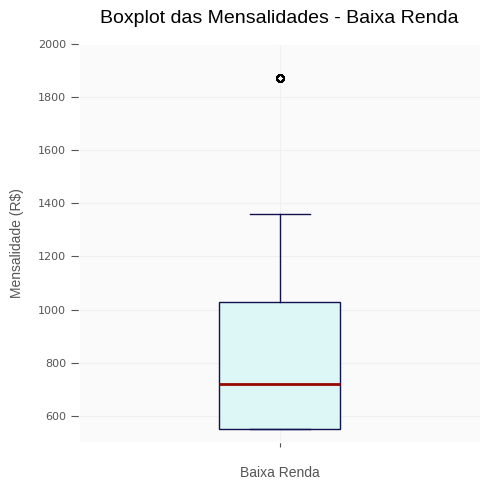

In [500]:
# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

# Remover valores nulos para a faixa de renda Baixa
cassi_baixa_renda = cassi[cassi['FAIXA_RENDA'] == 'Baixa renda']['VALOR_MENSALIDADE'].dropna()

# Verifique a quantidade de dados após a remoção de nulos
print(f"Baixa Renda - Dados: {cassi_baixa_renda.shape}")

# Preparar a figura (fig) e área do gráfico (ax) com largura 15 e altura 7
fig, ax = plt.subplots(figsize=(5, 5))

# Boxplot para Baixa Renda
ax.boxplot(
    cassi_baixa_renda,
    widths=0.3,
    patch_artist=True,
    boxprops=dict(facecolor='#DDF6F6', color='#11114E'),
    whiskerprops=dict(color='#11114E'),
    capprops=dict(color='#11114E'),
    flierprops=dict(marker='o', markersize=5),
    medianprops=dict(color='#970700', linewidth=2)
)
ax.set_title('Boxplot das Mensalidades - Baixa Renda', fontsize=14, fontname='Liberation Sans', loc='center', pad=15)
ax.set_xlabel('Baixa Renda', fontsize=10, fontname='Liberation Sans', labelpad = 10)
ax.set_ylabel('Mensalidade (R$)', fontsize=10, fontname='Liberation Sans', labelpad = 10)

# Evitar o warning que aparece tem essa linha (stack exchange)
ax.tick_params(axis='y', labelsize=8, length=6)
ax.set_xticklabels([])
ax.set_ylim(500, 2000)

# Ajustar layout para garantir que o gráfico não se sobreponha
plt.tight_layout()

# Exibir o gráfico do boxplot de Baixa Renda
plt.show()

In [501]:
#Distribuição de valores faltantes nas rendas:

for renda in ['Baixa renda', 'Média renda', 'Alta renda']:
    nan_quantidade = cassi[cassi['FAIXA_RENDA'] == renda]['VALOR_MENSALIDADE'].isnull().sum()
    print(f'Linhas de {renda} com dados faltantes de mensalidade: {nan_quantidade}')

Linhas de Baixa renda com dados faltantes de mensalidade: 21455
Linhas de Média renda com dados faltantes de mensalidade: 8192
Linhas de Alta renda com dados faltantes de mensalidade: 3743


In [502]:
for renda in ['Baixa renda', 'Média renda', 'Alta renda']:
    mediana = cassi[cassi['FAIXA_RENDA'] == renda]['VALOR_MENSALIDADE'].median()
    print(f'Mediana de {renda}: {mediana}')



Mediana de Baixa renda: 720.0
Mediana de Média renda: 720.0
Mediana de Alta renda: 720.0


######Idade
Sabemos que a IDADE é um atributo que influencia muito no valor dos planos de saúde. Vamos aproveitar para limpar os dados referentes à idade:

In [503]:
#analisando estatísticas
media_idade = cassi['IDADENAADESÃO'].mean()
mediana_idade = cassi['IDADENAADESÃO'].median()
maximo_idade = cassi['IDADENAADESÃO'].max()
minimo_idade = cassi['IDADENAADESÃO'].min()

# Exibindo as estatísticas
print(f'Média da IDADE NA ADESÃO: {media_idade}')
print(f'Mediana da IDADE NA ADESÃO: {mediana_idade}')
print(f'Máximo da IDADE NA ADESÃO: {maximo_idade}')
print(f'Mínimo da IDADE NA ADESÃO: {minimo_idade}')

Média da IDADE NA ADESÃO: 30.864672505921884
Mediana da IDADE NA ADESÃO: 29.0
Máximo da IDADE NA ADESÃO: 249
Mínimo da IDADE NA ADESÃO: -19


Como para o atributo IDADENAADESÃO não faz sentido números muito grandes, negativos, ou menores de 18 (em caso de titulares), vamos começar a organizar essa coluna.

Como a pessoa mais velha do mundo tem 116 anos, vamos limitar a essa idade as possíveis idades de adesão.

In [504]:
cassi['IDADENAADESÃO'].dtype

dtype('int64')

In [505]:
#linhas com idade maior que 116 e negativa
idade_maior_116 = cassi[cassi['IDADENAADESÃO'] > 116]
idade_negativa = cassi[cassi['IDADENAADESÃO'] < 0]
idades_erradas_combinadas = pd.concat([idade_maior_116, idade_negativa])
idades_erradas_combinadas



,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE
35,111561,TITULAR,SIM,Baixa renda,222,290,M,SP,NÃO,3,0,NaN
152,138004,TITULAR,NÃO,Baixa renda,233,310,F,PE,NÃO,7,1,1030.0
451,114827,TITULAR,NÃO,Média renda,203,309,M,RJ,NÃO,53,2,1030.0
452,60671,TITULAR,SIM,Baixa renda,230,249,F,SP,NÃO,57,2,1870.0
458,64386,TITULAR,NÃO,Alta renda,232,309,F,SP,NÃO,8,0,1030.0
...,...,...,...,...,...,...,...,...,...,...,...,...
100848,50385,TITULAR,SIM,Baixa renda,-11,271,F,BA,SIM,29,2,1870.0
100952,124898,TITULAR,SIM,Baixa renda,-13,289,F,SP,SIM,10,3,1030.0
100984,75324,TITULAR,SIM,Baixa renda,-1,203,M,RS,NÃO,9,1,NaN
101033,72671,TITULAR,NÃO,Média renda,-17,299,M,PA,NÃO,10,1,NaN


In [506]:
cassi_idade_não_alterada = cassi.copy()

In [507]:
cassi = cassi.drop(idades_erradas_combinadas.index)

In [508]:
#verificando se funcionou
cassi[cassi['IDADENAADESÃO'] > 116]

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE


In [509]:
#verificando se funcionou
cassi[cassi['IDADENAADESÃO'] < 0]

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE


Além disso, não é possível entrar no concurso do Banco do Brasil com menos de 18 anos, logo essa é uma limitação de negócio para a CASSI (para titulares). Como essas pessoas estão no sistema e tem um ID, provavelmente o erro é proveniente de alguma manipulação da tabela. Para todos as instâncias que tenham menos de 18 anos, vamos mudar para "DEPENDENTE" as que não tiverem esse label.

**OBSERVAÇÃO:** Num caso real, eu perguntaria para algum steakholder as regras de negócio, então estou supondo algumas coisas que perguntaria se fosse um caso real.

In [510]:
cassi_dependente_nao_alterado = cassi.copy()

In [511]:
cassi['TITULARIDADE'] = cassi.apply(
    lambda row: 'DEPENDENTE' if row['IDADENAADESÃO'] < 18 and row['TITULARIDADE'] == 'TITULAR'
    else row['TITULARIDADE'],
    axis = 1

)

In [512]:
#verificando se funcionou
titulares_menos_18 = cassi[ (cassi['IDADENAADESÃO'] < 18) & (cassi['TITULARIDADE'] == 'TITULAR')]
titulares_menos_18

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE


Em geral, os planos ficam mais caros de acordo com a idade da pessoa (mudam de faixas), logo vamos adicionar a coluna "IDADEATUAL", referente à idade atual da pessoa.

Essa conta pode ser feita considerando a idade de adesão e o tempo que a pessoa tem o plano:


In [513]:
# Adicionando a coluna 'IDADENAADESÃO' em meses
cassi['IDADEATUAL'] = cassi['IDADENAADESÃO'] + (cassi['TEMPO_DE_PLANO_MESES'] / 12).astype(int)
cassi.columns


Index(['ID_CLIENTE', 'TITULARIDADE', 'CANCELADO', 'FAIXA_RENDA',
       'IDADENAADESÃO', 'TEMPO_DE_PLANO_MESES', 'SEXO', 'UF', 'INADIMPLENTE',
       'QTD_CONSULTAS_12M', 'QTD_INTERNACOES_12M', 'VALOR_MENSALIDADE',
       'IDADEATUAL'],
      dtype='object')

In [514]:
cassi.head()

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE,IDADEATUAL
0,53100,TITULAR,NÃO,Média renda,39,302,F,RJ,NÃO,12,1,1030.0,64
1,140400,TITULAR,NÃO,Média renda,24,307,F,BA,NÃO,4,0,720.0,49
2,105059,DEPENDENTE,NÃO,Média renda,1,295,M,MG,NÃO,6,7,NaN,25
3,82963,TITULAR,NÃO,Média renda,36,294,M,RJ,NÃO,21,1,1030.0,60
4,97768,TITULAR,SIM,Baixa renda,20,259,F,RN,NÃO,30,0,550.0,41


In [515]:
cassi.to_csv('cassi.csv', index=False)

Agora a ideia é analisar qual a correlação entre a IDADE ATUAL e VALOR DE MENSALIDADE, então vamos usar a Matriz de Correlação:



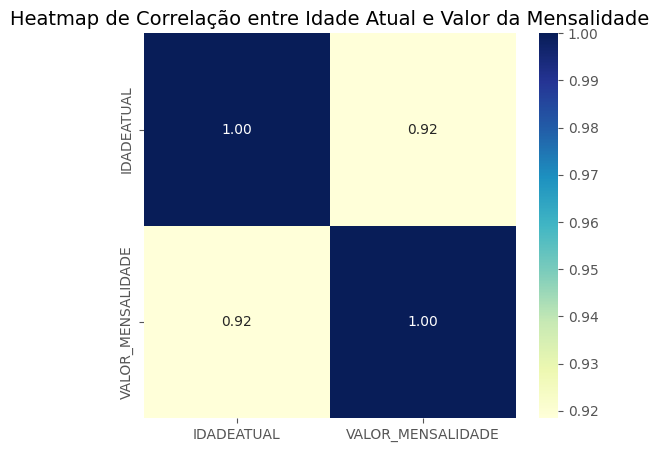

In [516]:
correlacao_matrix = cassi[['IDADEATUAL', 'VALOR_MENSALIDADE']].corr()


plt.figure(figsize=(6, 5))
sns.heatmap(correlacao_matrix, annot=True, cmap='YlGnBu', fmt='.2f', cbar=True)
plt.title('Heatmap de Correlação entre Idade Atual e Valor da Mensalidade', fontsize=14)
plt.show()

O heatmap de correlação mostra que IDADEATUAL e VALOR_MENSALIDADE tem uma correlação positiva forte (0.92). Analisando o contexto do problema (Plano de Saúde), faz sentido adicionarmos algumas outras variáveis explicativas ao problema de completar as mensalidades faltantes:

*   **Idade Atual:** vimos que existe uma correlação grande entre esse atributo e a mensalidade.
*   **Idade na Adesão:** aqui queremos identificar se o Plano de Saúde teria valores de mensalidades diferentes para diferentes faixas etárias no momento da adesão.
*   **Tempo de Plano:** pode estar relacionado com descontos, aumentos e variações na mensalidade.

Dito isso, vamos usar Machine Learning para completar os valores faltantes de mensalidade.

Algumas observações: poderíamos usar apenas a variável idade para simplificar o modelo, mas acho que o grau de complexibilidade que vamos adicionar faz sentido ser adicionado para um resultado mais preciso.

######Completando mensalidades com ML

Primeiro vamos verificar se há multicolinearidade entre as variáveis usando VIF:

In [517]:
#VIF
variaveis_explicativas = cassi[['IDADEATUAL', 'IDADENAADESÃO', 'TEMPO_DE_PLANO_MESES']]

variaveis_explicativas_const = add_constant(variaveis_explicativas)

# Calcular o VIF para cada variável
vif = pd.DataFrame()
vif['Variável'] = variaveis_explicativas_const.columns
vif['VIF'] = [variance_inflation_factor(variaveis_explicativas_const.values, i) for i in range(variaveis_explicativas_const.shape[1])]

print(vif)

               Variável          VIF
0                 const    30.229648
1            IDADEATUAL  4742.249948
2         IDADENAADESÃO  4520.670563
3  TEMPO_DE_PLANO_MESES   204.319309


Para reduzir a multicolinearidade vamos retirar uma das variáveis: IDADENAADESÃO (visto que o valor do VIF é extremamente alto para duas das variáveis), o que pode atrapalhar nossa predição:

In [518]:
#VIF
variaveis_explicativas = cassi[['IDADEATUAL', 'TEMPO_DE_PLANO_MESES']]

variaveis_explicativas_const = add_constant(variaveis_explicativas)

# Calcular o VIF para cada variável
vif = pd.DataFrame()
vif['Variável'] = variaveis_explicativas_const.columns
vif['VIF'] = [variance_inflation_factor(variaveis_explicativas_const.values, i) for i in range(variaveis_explicativas_const.shape[1])]

print(vif)

               Variável        VIF
0                 const  29.630719
1            IDADEATUAL   1.049110
2  TEMPO_DE_PLANO_MESES   1.049110


Mesmo que a variável VALOR_MENSALIDADE seja numérica, ou seja, em teoria vamos prever algo numérico, note que temos apenas 5 possibilidades de mensalidade, então podemos considerar um problema de classificação.

Algumas opções que podem ser utilizadas: **Random Forest Classifier**, **Árvores de Decisão** ou **KNN**.

Não vamos usar o KNN, pois como temos muitas instâncias teria um alto custo computacional e lentidão.

Árvores de Decisão: em grandes conjuntos de dados (nosso caso), a probabilidade de overfitting é maior.

Portanto, vamos utilizar `Random Forest Classifier`.

In [519]:
valores_faltantes('IDADEATUAL', cassi)
valores_faltantes('TEMPO_DE_PLANO_MESES', cassi)

❌ Nenhuma célula na coluna "IDADEATUAL" é vazia.

❌ Nenhuma célula na coluna "TEMPO_DE_PLANO_MESES" é vazia.



False

In [520]:
tempos_negativos_cassi = cassi[cassi['TEMPO_DE_PLANO_MESES'] < 0]

# Exibir as instâncias com valores negativos
print(tempos_negativos_cassi)


       ID_CLIENTE TITULARIDADE CANCELADO  FAIXA_RENDA  IDADENAADESÃO  \
31999       61807   DEPENDENTE       NÃO  Média renda              2   
45563       91562   DEPENDENTE       NÃO  Média renda              2   

       TEMPO_DE_PLANO_MESES SEXO  UF INADIMPLENTE  QTD_CONSULTAS_12M  \
31999                   -22    F  BA          NÃO                  8   
45563                   -22    F  BA          NÃO                 18   

       QTD_INTERNACOES_12M  VALOR_MENSALIDADE  IDADEATUAL  
31999                    1              550.0           1  
45563                    3                NaN           1  


In [521]:
cassi = cassi.drop([31999, 45563])


In [522]:
tempos_negativos_cassi2 = cassi[cassi['TEMPO_DE_PLANO_MESES'] < 0]
print(tempos_negativos_cassi2)

Empty DataFrame
Columns: [ID_CLIENTE, TITULARIDADE, CANCELADO, FAIXA_RENDA, IDADENAADESÃO, TEMPO_DE_PLANO_MESES, SEXO, UF, INADIMPLENTE, QTD_CONSULTAS_12M, QTD_INTERNACOES_12M, VALOR_MENSALIDADE, IDADEATUAL]
Index: []


In [523]:
cassi['TEMPO_DE_PLANO_MESES'].max()

311

In [524]:
cassi['IDADEATUAL'].max()

113

In [525]:
cassi['IDADEATUAL'].min()

10

Queremos completar apenas as instâncias que não tem VALOR_MENSALIDADE, portanto vamos separar o dataset em dois conjuntos:


In [526]:
#separando dados de treino e teste
cassi_treino_teste = cassi[cassi['VALOR_MENSALIDADE'].notna()]
cassi_treino_teste.head()

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE,IDADEATUAL
0,53100,TITULAR,NÃO,Média renda,39,302,F,RJ,NÃO,12,1,1030.0,64
1,140400,TITULAR,NÃO,Média renda,24,307,F,BA,NÃO,4,0,720.0,49
3,82963,TITULAR,NÃO,Média renda,36,294,M,RJ,NÃO,21,1,1030.0,60
4,97768,TITULAR,SIM,Baixa renda,20,259,F,RN,NÃO,30,0,550.0,41
9,134178,TITULAR,SIM,Baixa renda,31,293,F,MS,NÃO,5,1,1030.0,55


In [527]:
cassi_validacao = cassi[cassi['VALOR_MENSALIDADE'].isna()]
cassi_validacao.head()

,ID_CLIENTE,TITULARIDADE,CANCELADO,FAIXA_RENDA,IDADENAADESÃO,TEMPO_DE_PLANO_MESES,SEXO,UF,INADIMPLENTE,QTD_CONSULTAS_12M,QTD_INTERNACOES_12M,VALOR_MENSALIDADE,IDADEATUAL
2,105059,DEPENDENTE,NÃO,Média renda,1,295,M,MG,NÃO,6,7,NaN,25
5,91139,DEPENDENTE,SIM,Baixa renda,3,268,F,PA,SIM,27,0,NaN,25
6,88445,TITULAR,SIM,Baixa renda,66,274,F,RJ,NÃO,32,1,NaN,88
7,52541,TITULAR,NÃO,Média renda,39,308,M,BA,NÃO,2,4,NaN,64
8,58821,TITULAR,NÃO,Baixa renda,35,294,M,RJ,NÃO,1,0,NaN,59


In [528]:
cassi_treino_teste.columns

Index(['ID_CLIENTE', 'TITULARIDADE', 'CANCELADO', 'FAIXA_RENDA',
       'IDADENAADESÃO', 'TEMPO_DE_PLANO_MESES', 'SEXO', 'UF', 'INADIMPLENTE',
       'QTD_CONSULTAS_12M', 'QTD_INTERNACOES_12M', 'VALOR_MENSALIDADE',
       'IDADEATUAL'],
      dtype='object')

Podemos usar **holdout** ou **cross validation** para separar em dados de treino e dados de teste. Nesse caso, temos um conjunto de dados com muitas instâncias, então vamos usar o holdout (em um outro contexto com mais tempo, poderíamos usar cross validation).

Vamos usar `train_test_split` e dividir os dados em 80% de treinamento e 20% de teste.


Não vamos precisa normalizar os dados nesse caso, pois o Random Forest Classifier é invariante à escala de variáveis.

In [529]:

X = cassi_treino_teste[['IDADEATUAL', 'TEMPO_DE_PLANO_MESES']]  # Variáveis explicativas

# Manter VALOR_MENSALIDADE apenas como a variável alvo (y)
y = cassi_treino_teste['VALOR_MENSALIDADE']  # Variável alvo (mensalidade)

# Agora, você pode dividir os dados entre treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
modelo_rf_mensalidade = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, min_samples_split=10, class_weight='balanced')
modelo_rf_mensalidade.fit(X_train, y_train)

# Fazer as previsões e avaliar a performance
y_pred = modelo_rf_mensalidade.predict(X_test)

# Exibir o relatório de classificação
from sklearn.metrics import classification_report
relatorio = classification_report(y_test, y_pred)
print("Relatório de Classificação:\n", relatorio)


Relatório de Classificação:
               precision    recall  f1-score   support

       550.0       1.00      1.00      1.00      3897
       720.0       1.00      1.00      1.00      2134
      1030.0       1.00      1.00      1.00      3007
      1360.0       1.00      1.00      1.00      1231
      1870.0       1.00      1.00      1.00       986

    accuracy                           1.00     11255
   macro avg       1.00      1.00      1.00     11255
weighted avg       1.00      1.00      1.00     11255



Note que o modelo **Random Forest** está apresentando overfitting mesmo depois de usar algumas possíveis soluções para isso (balancear as classes, por exemplo).

In [530]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Treinar o modelo Naive Bayes
modelo_nb_mensalidade = GaussianNB()
modelo_nb_mensalidade.fit(X_train, y_train)

# Fazer as previsões
y_pred = modelo_nb_mensalidade.predict(X_test)

# Exibir o relatório de classificação
relatorio = classification_report(y_test, y_pred)
print("Relatório de Classificação:\n", relatorio)


Relatório de Classificação:
               precision    recall  f1-score   support

       550.0       0.93      0.92      0.92      3897
       720.0       0.68      0.73      0.70      2134
      1030.0       0.83      0.82      0.83      3007
      1360.0       0.82      0.78      0.80      1231
      1870.0       0.93      0.91      0.92       986

    accuracy                           0.84     11255
   macro avg       0.84      0.83      0.83     11255
weighted avg       0.84      0.84      0.84     11255



Como não temos classes de valores de mensalidades balanceadas, acurácia não seria uma boa métrica comparativa. Vamos usar `F1 score`, poir estamos num caso de classes desbalanceadas e queremos balancear precisão e recall.



In [531]:
#calcular f1-score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1-score (Ponderada) de modelo_nb_mensalidade é: {f1:.4f}")

F1-score (Ponderada) de modelo_nb_mensalidade é: 0.8406


Note que os dados não estão numa escala parecida, então vamos normalizar para tentar melhorar o f1-score:

In [532]:
# Normalizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Normalizando os dados de treino
X_test_scaled = scaler.transform(X_test)  # Usando o mesmo "fit" nos dados de teste

# Treinar o modelo Naive Bayes
modelo_nb_mensalidade_norm = GaussianNB()
modelo_nb_mensalidade_norm.fit(X_train_scaled, y_train)

# Fazer as previsões
y_pred = modelo_nb_mensalidade_norm.predict(X_test_scaled)

# Exibir o relatório de classificação
relatorio = classification_report(y_test, y_pred)
print("Relatório de Classificação:\n", relatorio)

Relatório de Classificação:
               precision    recall  f1-score   support

       550.0       0.93      0.92      0.92      3897
       720.0       0.68      0.73      0.70      2134
      1030.0       0.83      0.82      0.83      3007
      1360.0       0.82      0.78      0.80      1231
      1870.0       0.93      0.91      0.92       986

    accuracy                           0.84     11255
   macro avg       0.84      0.83      0.83     11255
weighted avg       0.84      0.84      0.84     11255



In [533]:
#calcular f1-score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"F1-score (Ponderada) de modelo_nb_mensalidade_norm é: {f1:.4f}")

F1-score (Ponderada) de modelo_nb_mensalidade_norm é: 0.8406


O modelos escolhido será modelo_nb_mensalidade, ele tem um f1-score de 0.8406, que é um valor aceitável no nosso caso. Agora vamos usar esse classificados nos exemplos não rotulados do conjunto de dados:

In [534]:
X_validacao = cassi_validacao[['IDADEATUAL', 'TEMPO_DE_PLANO_MESES']]

# Fazer as previsões no conjunto de validação
y_validacao_pred = modelo_nb_mensalidade.predict(X_validacao)

# Exibir as previsões (rótulos previstos para os exemplos reais)
print("Rótulos previstos para os exemplos de validação:")
print(y_validacao_pred)


Rótulos previstos para os exemplos de validação:
[ 550.  550. 1870. ...  550. 1030. 1870.]


In [535]:
#substituindo o valor de VALOR_MENSALIDADE pelas classes previstas

cassi_validacao['VALOR_MENSALIDADE'] = y_validacao_pred

print(cassi_validacao[['IDADEATUAL', 'TEMPO_DE_PLANO_MESES', 'VALOR_MENSALIDADE']].head())

   IDADEATUAL  TEMPO_DE_PLANO_MESES  VALOR_MENSALIDADE
2          25                   295              550.0
5          25                   268              550.0
6          88                   274             1870.0
7          64                   308             1030.0
8          59                   294             1030.0


/tmp/ipython-input-1467819241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cassi_validacao['VALOR_MENSALIDADE'] = y_validacao_pred


In [536]:
# Combinar o DataFrame de validação com o DataFrame de treino/teste (que agora está completo)
cassi = pd.concat([cassi_validacao, cassi_treino_teste], ignore_index=True)

# Verificar se a combinação foi bem-sucedida
print(cassi.head())
print(cassi.tail())

# Se você quiser salvar o novo DataFrame combinado, pode fazer assim:
cassi.to_csv("cassi_combinado.csv", index=False)


   ID_CLIENTE TITULARIDADE CANCELADO  FAIXA_RENDA  IDADENAADESÃO  \
0      105059   DEPENDENTE       NÃO  Média renda              1   
1       91139   DEPENDENTE       SIM  Baixa renda              3   
2       88445      TITULAR       SIM  Baixa renda             66   
3       52541      TITULAR       NÃO  Média renda             39   
4       58821      TITULAR       NÃO  Baixa renda             35   

   TEMPO_DE_PLANO_MESES SEXO  UF INADIMPLENTE  QTD_CONSULTAS_12M  \
0                   295    M  MG          NÃO                  6   
1                   268    F  PA          SIM                 27   
2                   274    F  RJ          NÃO                 32   
3                   308    M  BA          NÃO                  2   
4                   294    M  RJ          NÃO                  1   

   QTD_INTERNACOES_12M  VALOR_MENSALIDADE  IDADEATUAL  
0                    7              550.0          25  
1                    0              550.0          25  
2             

In [537]:
#verificando se temos valores de pensalidade em todas as instâncias:
cassi['VALOR_MENSALIDADE'].isna().sum()

np.int64(0)

<Axes: >

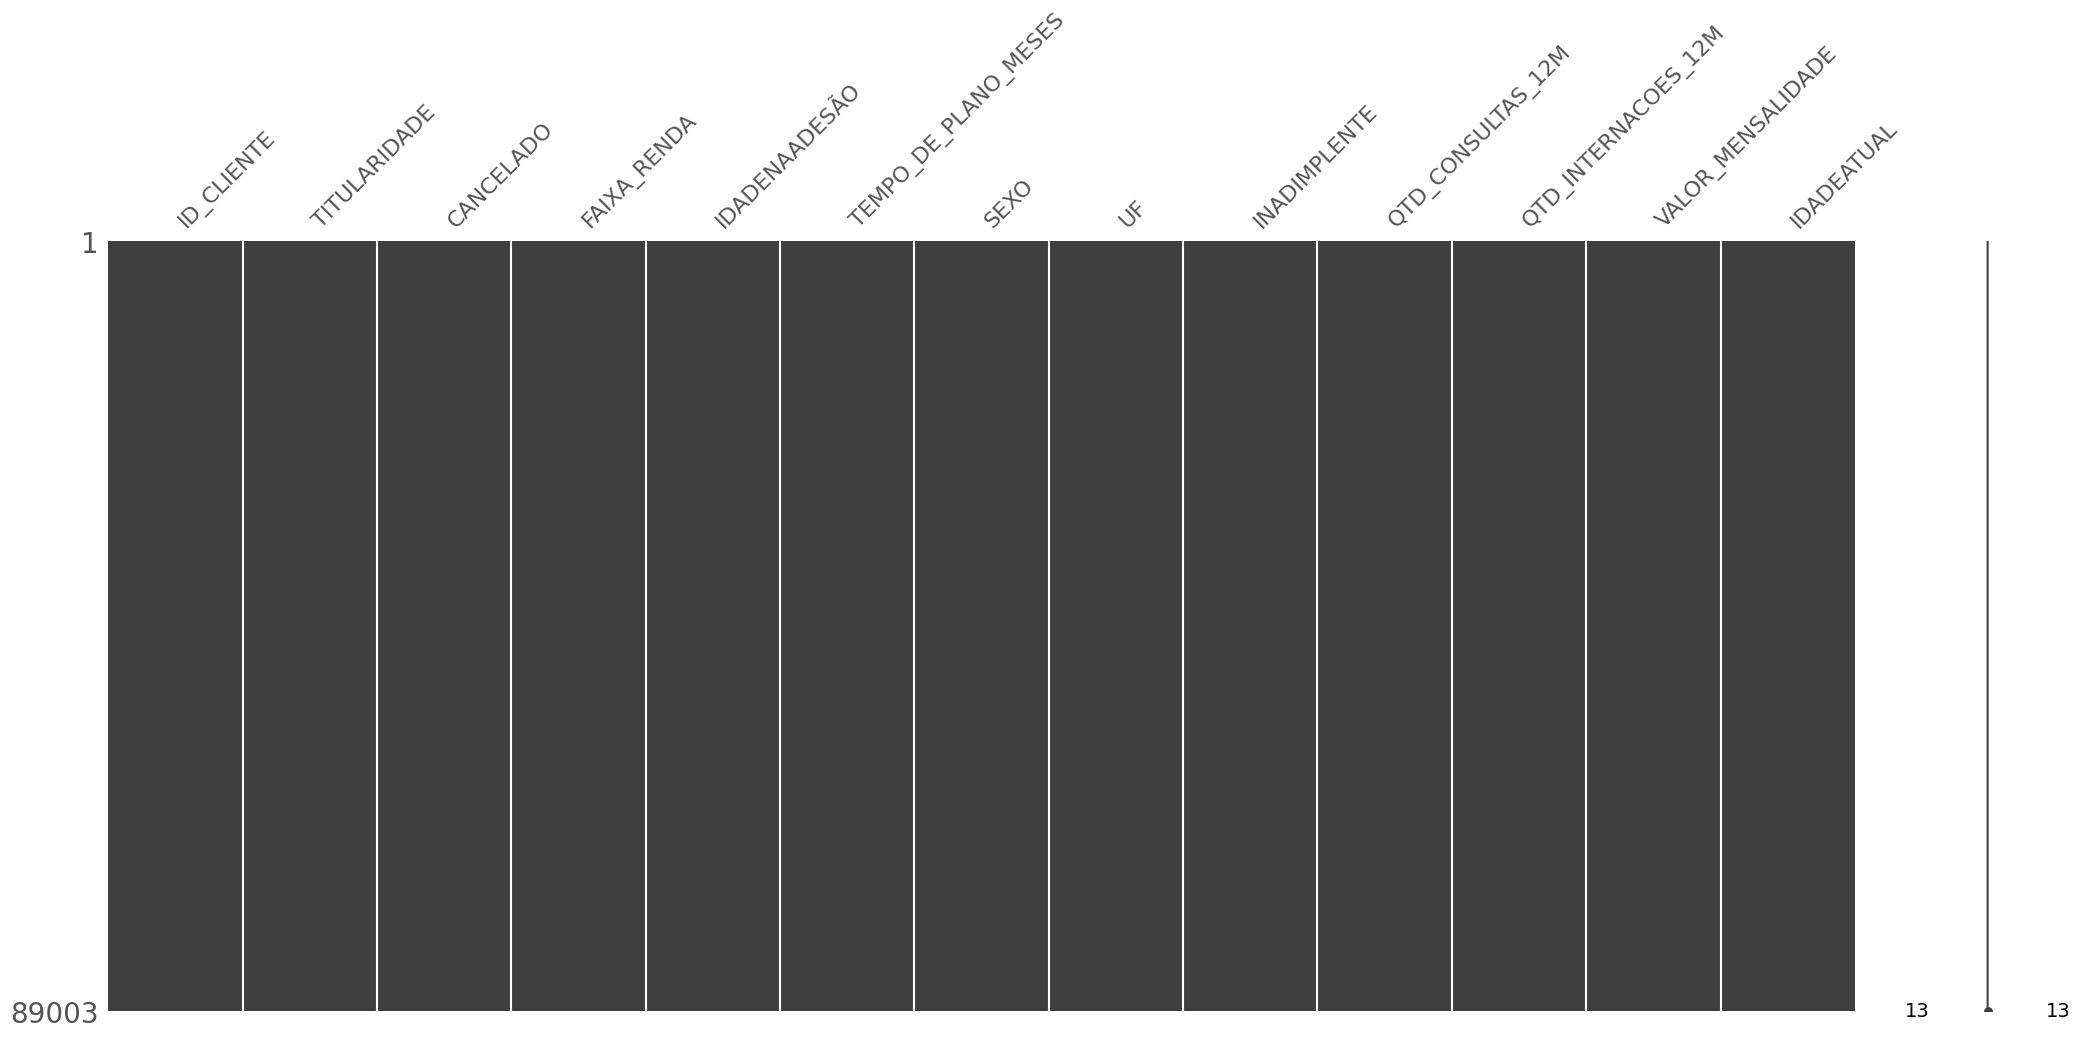

In [538]:
#verificando se algum outro atributo tem dados faltantes
ms.matrix(cassi)

###Outros Atributos

In [539]:
#verificando domínio

cassi['TITULARIDADE'].unique()

array(['DEPENDENTE', 'TITULAR'], dtype=object)

In [540]:
#verificando domínio
cassi['CANCELADO'].unique()

array(['NÃO', 'SIM'], dtype=object)

In [541]:
#verificando domínio
cassi['FAIXA_RENDA'].unique()


array(['Média renda', 'Baixa renda', 'Alta renda'], dtype=object)

In [542]:
#verificando domínio
cassi['SEXO'].unique()

array(['M', 'F'], dtype=object)

In [543]:
#verificando domínio
cassi['UF'].unique()

array(['MG', 'PA', 'RJ', 'BA', 'RS', 'SP', 'RN', 'PE', 'DF', 'CE', 'GO',
       'MA', 'ES', 'SE', 'AL', 'MT', 'PR', 'PB', 'SC', 'MS', 'PI', 'AM',
       'RO', 'AC', 'RR', 'AP', 'TO'], dtype=object)

In [544]:
#verificando domínio
cassi['INADIMPLENTE'].unique()

array(['NÃO', 'SIM'], dtype=object)

In [545]:
#verificando max e mínimo para detectar possíveis problemas
cassi['QTD_CONSULTAS_12M'].min()

1

In [546]:
#verificando max e mínimo para detectar possíveis problemas
cassi['QTD_INTERNACOES_12M'].max()

9

In [547]:
#verificando max e mínimo para detectar possíveis problemas
cassi['QTD_INTERNACOES_12M'].min()

0

In [548]:
#verificando max e mínimo para detectar possíveis problemas
cassi['QTD_INTERNACOES_12M'].max()

9

Verificamos todos os possíveis problemas com o conjunto de dados. Todos os dados faltantes foram resolvido, bem como problemas de domínio.

## Comparação entre grupos

Nesta etapa nosso objetivo é calcular `a taxa de churn`, comparando entre grupos e destacando as variáveis mais relevantes. Lembrando que a taxa de Churn pode ser definida por:

$$
\text{Taxa de Churn} = \frac{\text{Clientes Churned}}{\text{Total de Clientes}} \times 100
$$

A taxa de churn é a porcentagem de clientes que deixaram de usar o serviço. No nosso caso, seria a porcentagem de clientes com planos CANCELADOS em relação ao total de clientes.

In [549]:
# quantidade de planos cancelados
cassi[cassi['CANCELADO'] == 'SIM'].shape[0]

52373

In [550]:
# quantidade de clientes
cassi.shape[0]

89003

In [551]:
taxa_churn = round((52373/89003)*100, 2)
taxa_churn

58.84

$$
\text{Taxa de Churn} = \frac{52373}{\text{89003}} \times 100 = 58.84\%
$$

Agora que sabemos qual a taxa churn geral atual dos dados, vamos partir para o segundo ponto: comparar essa taxa entre os possíveis grupos que fazem sentido:

###Faixa Etária

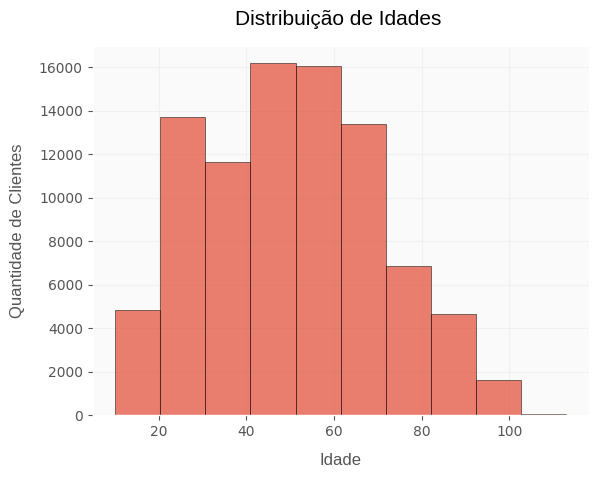

In [552]:
# Carrega folha de estilo
plt.style.use("ggplot")


# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

# Plotar o histograma para visualizar a distribuição das idades
plt.hist(cassi['IDADEATUAL'], bins=10, edgecolor='black', alpha=0.7)

# Adicionar título e rótulos
plt.title('Distribuição de Idades ', fontname='Liberation Sans', pad = 15, size = 15)
plt.xlabel('Idade', fontname='Liberation Sans', labelpad = 10)
plt.ylabel('Quantidade de Clientes', fontname='Liberation Sans', labelpad = 10)
#plt.xticks(faixas_etarias, labels=labels)  # Ajustar rótulos para as faixas
plt.grid(True)
plt.show()


Vamos definir classes de faixas etárias da seguinte maneira:

*   Classe 1: 18-25 anos
*   Classe 2: 26-35 anos
*   Classe 3: 36-45 anos
*   Classe 4: 46-60  anos
*   Classe 5: 60-69 anos
*   Classe 3: 70 ou mais

In [553]:
#adicionando coluna de idade

faixas_etarias = [18, 26, 36, 46, 61, 70, 116]
labels = ['18-25', '26-35', '36-45', '46-60', '61-69', '70 ou mais']

# Criar uma nova coluna 'Faixa Etária' no DataFrame
cassi['Faixa_Etaria'] = pd.cut(cassi['IDADEATUAL'], bins=faixas_etarias, labels=labels, right=False)

# Verificar as primeiras linhas para confirmar a coluna
print(cassi[['IDADEATUAL', 'Faixa_Etaria']].head())
print(cassi[['IDADEATUAL', 'Faixa_Etaria']].tail())

   IDADEATUAL Faixa_Etaria
0          25        18-25
1          25        18-25
2          88   70 ou mais
3          64        61-69
4          59        46-60
       IDADEATUAL Faixa_Etaria
88998          91   70 ou mais
88999          93   70 ou mais
89000          27        26-35
89001          86   70 ou mais
89002          75   70 ou mais


Faixa_Etaria
46-60         25601
70 ou mais    15427
26-35         13292
61-69         12547
36-45         10765
18-25          9630
Name: count, dtype: int64


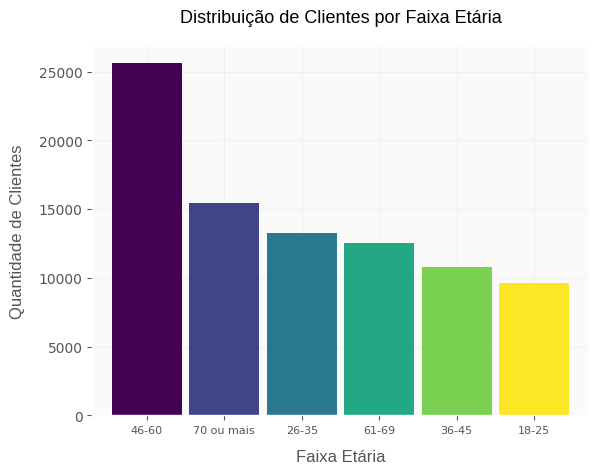

In [554]:
# Visualizar a quantidade de clientes em cada faixa etária
# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado
cmap = plt.cm.viridis

faixa_count = cassi['Faixa_Etaria'].value_counts()
print(faixa_count)
colors = cmap(np.linspace(0, 1, len(faixa_count)))

# Visualizar com um gráfico
faixa_count.plot(kind='bar', color=colors, width=0.9)
plt.title('Distribuição de Clientes por Faixa Etária', fontname='Liberation Sans', pad = 17, size = 13)
plt.xlabel('Faixa Etária', fontsize=12, fontname='Liberation Sans', labelpad = 10)
plt.ylabel('Quantidade de Clientes', fontsize=12, fontname='Liberation Sans', labelpad = 10)
plt.xticks(rotation=0, fontsize=8)

plt.show()

/tmp/ipython-input-2517232538.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cancelados_idade = cassi.groupby('Faixa_Etaria')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
/tmp/ipython-input-2517232538.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  qtd_total_idade = cassi.groupby('Faixa_Etaria').size()


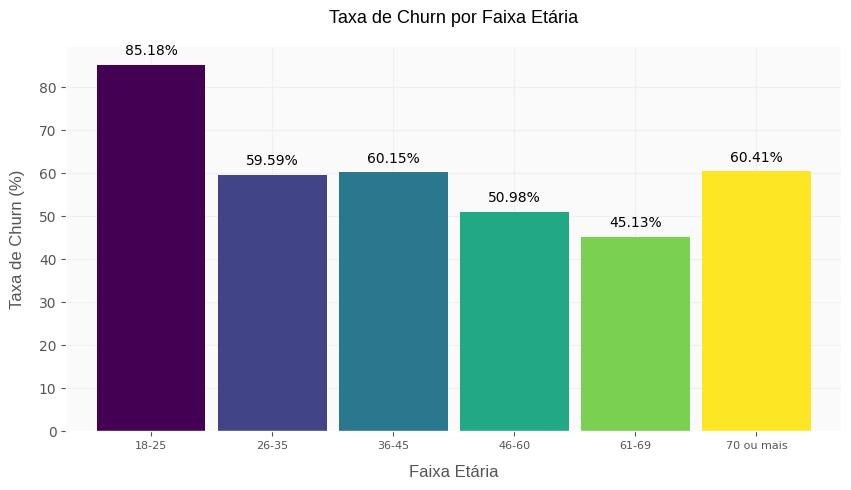

In [555]:
#Taxa Churn por idade

# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(10, 5))

cancelados_idade = cassi.groupby('Faixa_Etaria')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_idade = cassi.groupby('Faixa_Etaria').size()
taxa_churn_por_idade = (cancelados_idade)/(qtd_total_idade)*100

#cores inclusivas
colors = cmap(np.linspace(0, 1, len(taxa_churn_por_idade)))

# Visualizar com um gráfico
taxa_churn_por_idade.plot(kind='bar', color=colors, width=0.9)
ax.set_title('Taxa de Churn por Faixa Etária', fontname='Liberation Sans', pad=17, size=13)
ax.set_xlabel('Faixa Etária', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_xticklabels(taxa_churn_por_idade.index, rotation=0, fontsize=8)

# Adicionar os valores da taxa de churn em cima de cada barra
ax.bar_label(ax.containers[0], labels=[f'{v:.2f}%' for v in taxa_churn_por_idade], fontsize=10, color='black', padding=5)

plt.show()

###Renda

FAIXA_RENDA
Baixa renda    57208
Média renda    21921
Alta renda      9874
Name: count, dtype: int64


/tmp/ipython-input-2770106080.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, v + 2000, f'{faixa_percent[i]:.2f}%', ha='center', fontsize=10)


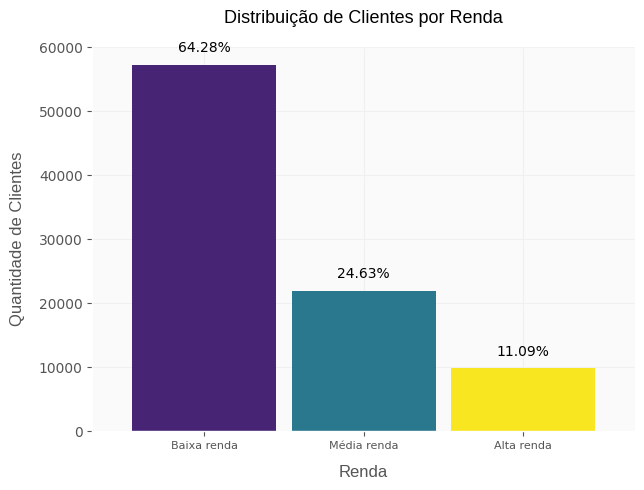

In [556]:
# Visualizar a quantidade de clientes em cada renda
# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado
cmap = plt.cm.viridis
cores = [cmap(0.1), cmap(0.4), cmap(0.99)]

fig, ax = plt.subplots(figsize=(7, 5))

faixa_count = cassi['FAIXA_RENDA'].value_counts()
print(faixa_count)


faixa_percent = faixa_count / faixa_count.sum() * 100

# Visualizar com um gráfico
faixa_count.plot(kind='bar', color=cores, width=0.9)
plt.title('Distribuição de Clientes por Renda', fontname='Liberation Sans', pad = 17, size = 13)
plt.xlabel('Renda', fontsize=12, fontname='Liberation Sans', labelpad = 10)
plt.ylabel('Quantidade de Clientes', fontsize=12, fontname='Liberation Sans', labelpad = 10)
plt.xticks(rotation=0, fontsize=8)

# Adicionar as porcentagens em cima das barras
for i, v in enumerate(faixa_count):
    ax.text(i, v + 2000, f'{faixa_percent[i]:.2f}%', ha='center', fontsize=10)

plt.show()

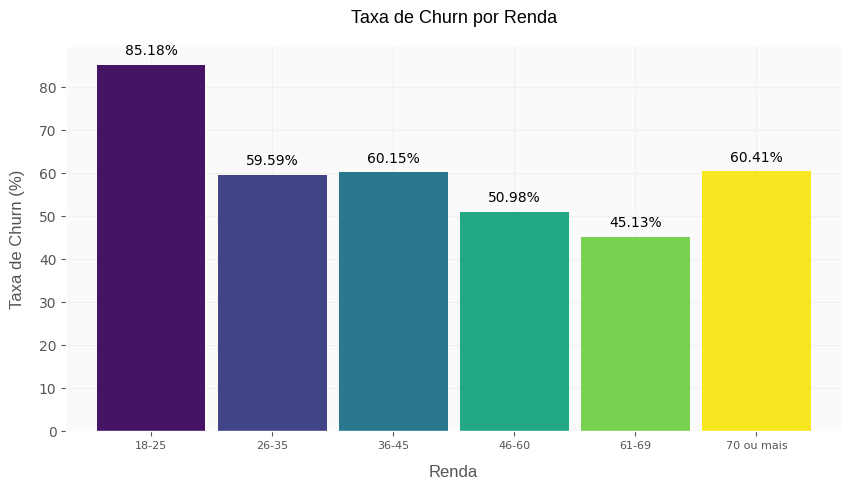

In [557]:
#Taxa Churn por Renda

# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(10, 5))

cancelados_renda = cassi.groupby('FAIXA_RENDA')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_renda = cassi.groupby('FAIXA_RENDA').size()
taxa_churn_por_renda = (cancelados_renda)/(qtd_total_renda)*100

#cores inclusivas
cores = [cmap(0.05), cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8), cmap(0.99)]

# Visualizar com um gráfico
taxa_churn_por_idade.plot(kind='bar', color=cores, width=0.9)
ax.set_title('Taxa de Churn por Renda', fontname='Liberation Sans', pad=17, size=13)
ax.set_xlabel('Renda', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_xticklabels(taxa_churn_por_idade.index, rotation=0, fontsize=8)

# Adicionar os valores da taxa de churn em cima de cada barra
ax.bar_label(ax.containers[0], labels=[f'{v:.2f}%' for v in taxa_churn_por_idade], fontsize=10, color='black', padding=5)

plt.show()

In [558]:

cancelados_renda1 = cassi.groupby('FAIXA_RENDA')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
cancelados_renda1

,CANCELADO
FAIXA_RENDA,
Alta renda,2610
Baixa renda,49763
Média renda,0


###Quantidade de consultas e internações

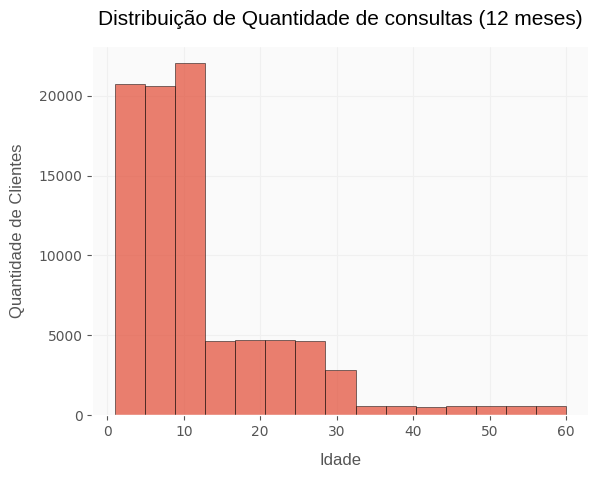

In [559]:
#quantidade de consultas
# Carrega folha de estilo
plt.style.use("ggplot")


# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

# Plotar o histograma para visualizar a distribuição das QTD_CONSULTAS_12M
plt.hist(cassi['QTD_CONSULTAS_12M'], bins=15, edgecolor='black', alpha=0.7)

# Adicionar título e rótulos
plt.title('Distribuição de Quantidade de consultas (12 meses)', fontname='Liberation Sans', pad = 15, size = 15)
plt.xlabel('Idade', fontname='Liberation Sans', labelpad = 10)
plt.ylabel('Quantidade de Clientes', fontname='Liberation Sans', labelpad = 10)
#plt.xticks(faixas_etarias, labels=labels)  # Ajustar rótulos para as faixas
plt.grid(True)
plt.show()

Como a distrubuição é assimétrica, podemos usar a implementação de faixas baseadas nos quartis:

In [560]:
q1 = cassi['QTD_CONSULTAS_12M'].quantile(0.25)
q2 = cassi['QTD_CONSULTAS_12M'].quantile(0.5)
q3 = cassi['QTD_CONSULTAS_12M'].quantile(0.75)

# Criar uma nova coluna de faixas de consultas
def categorize_consultas(x):
    if x <= q1:
        return 'Baixo (0-5)'
    elif x <= q2:
        return 'Médio (6-10)'
    elif x <= q3:
        return 'Alto (11-20)'
    else:
        return 'Muito Alto (>20)'

cassi['Faixa_Consultas'] = cassi['QTD_CONSULTAS_12M'].apply(categorize_consultas)

# Verificando as faixas criadas
print(cassi['Faixa_Consultas'].value_counts())

Faixa_Consultas
Baixo (0-5)         25731
Muito Alto (>20)    22132
Médio (6-10)        20757
Alto (11-20)        20383
Name: count, dtype: int64


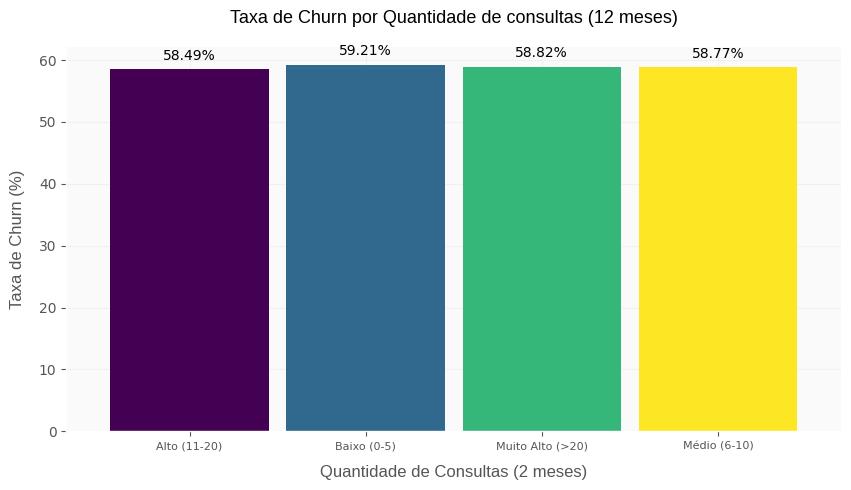

In [561]:
#Taxa Churn por idade

# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(10, 5))

cancelados_consultas = cassi.groupby('Faixa_Consultas')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_consultas = cassi.groupby('Faixa_Consultas').size()
taxa_churn_por_consultas = (cancelados_consultas)/(qtd_total_consultas)*100

#cores inclusivas
colors = cmap(np.linspace(0, 1, len(taxa_churn_por_consultas)))

# Visualizar com um gráfico
taxa_churn_por_consultas.plot(kind='bar', color=colors, width=0.9)

ax.set_title('Taxa de Churn por Quantidade de consultas (12 meses)', fontname='Liberation Sans', pad=17, size=13)
ax.set_xlabel('Quantidade de Consultas (2 meses)', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_xticklabels(taxa_churn_por_consultas.index, rotation=0, fontsize=8)

# Adicionar os valores da taxa de churn em cima de cada barra
ax.bar_label(ax.containers[0], labels=[f'{v:.2f}%' for v in taxa_churn_por_consultas], fontsize=10, color='black', padding=5)

plt.show()

In [562]:
# Criar novas faixas de consultas com base na nova abordagem
def categorize_consultas_novas(x):
    if x <= 1:
        return 'Baixo (0-1)'
    elif x <= 5:
        return 'Moderado (2-5)'
    elif x <= 15:
        return 'Alto (6-15)'
    else:
        return 'Muito Alto (>15)'

# Aplicar a função para criar as novas faixas
cassi['Faixa_Consultas_Nova'] = cassi['QTD_CONSULTAS_12M'].apply(categorize_consultas_novas)

# Verificando a quantidade de clientes em cada faixa
faixas_novas_consultas = cassi['Faixa_Consultas_Nova'].value_counts()
print(faixas_novas_consultas)


Faixa_Consultas_Nova
Alto (6-15)         41140
Muito Alto (>15)    22132
Moderado (2-5)      20545
Baixo (0-1)          5186
Name: count, dtype: int64


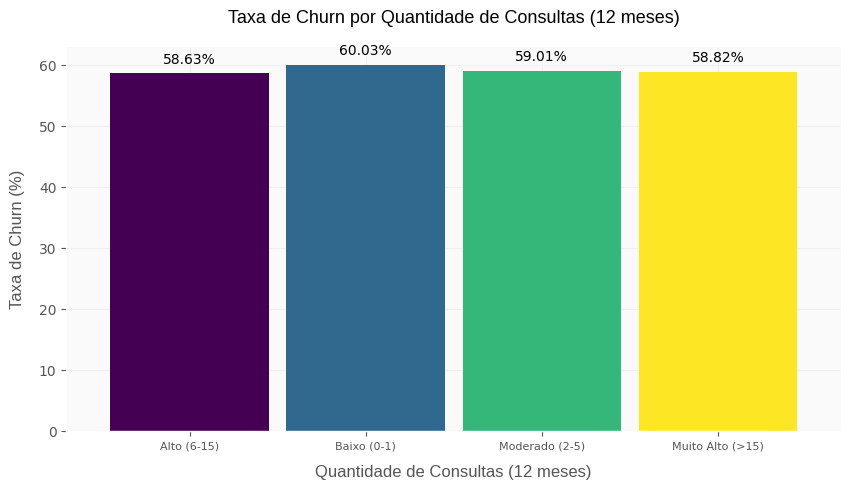

In [563]:
# Taxa Churn por Quantidade de Consultas (usando as novas faixas)

# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(10, 5))

# Calcular os cancelamentos e o total de clientes por nova faixa de consultas
cancelados_consultas = cassi.groupby('Faixa_Consultas_Nova')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_consultas = cassi.groupby('Faixa_Consultas_Nova').size()

# Calcular a taxa de churn por faixa de consultas
taxa_churn_por_consultas = (cancelados_consultas) / (qtd_total_consultas) * 100

# Definir as cores
colors = cmap(np.linspace(0, 1, len(taxa_churn_por_consultas)))

# Visualizar com um gráfico
taxa_churn_por_consultas.plot(kind='bar', color=colors, width=0.9, ax=ax)

# Ajustando título, rótulos e o eixo X
ax.set_title('Taxa de Churn por Quantidade de Consultas (12 meses)', fontname='Liberation Sans', pad=17, size=13)
ax.set_xlabel('Quantidade de Consultas (12 meses)', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=12, fontname='Liberation Sans', labelpad=10)

# Ajustar os rótulos do eixo X com base nas faixas
ax.set_xticklabels(taxa_churn_por_consultas.index, rotation=0, fontsize=8)

# Adicionar as taxas de churn em cima das barras
ax.bar_label(ax.containers[0], labels=[f'{v:.2f}%' for v in taxa_churn_por_consultas], fontsize=10, color='black', padding=5)

# Exibir o gráfico
plt.show()


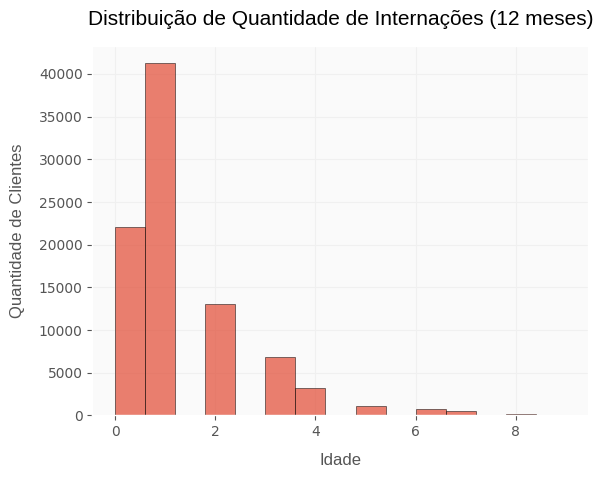

In [564]:
#quantidade de internações (12 meses)
# Carrega folha de estilo
plt.style.use("ggplot")


# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

# Plotar o histograma para visualizar a distribuição das QTD_CONSULTAS_12M
plt.hist(cassi['QTD_INTERNACOES_12M'], bins=15, edgecolor='black', alpha=0.7)

# Adicionar título e rótulos
plt.title('Distribuição de Quantidade de Internações (12 meses)', fontname='Liberation Sans', pad = 15, size = 15)
plt.xlabel('Idade', fontname='Liberation Sans', labelpad = 10)
plt.ylabel('Quantidade de Clientes', fontname='Liberation Sans', labelpad = 10)
#plt.xticks(faixas_etarias, labels=labels)  # Ajustar rótulos para as faixas
plt.grid(True)
plt.show()

In [565]:
# Criar novas faixas de consultas com base na nova abordagem
def categorize_consultas_novas(x):
    if x < 1:
        return 'Nenhuma (0)'
    elif x < 2:
        return 'Uma (1)'
    elif x < 3:
        return 'Duas (2)'
    else:
        return 'Alto (>5)'

# Aplicar a função para criar as novas faixas
cassi['Faixa_Internacoes'] = cassi['QTD_INTERNACOES_12M'].apply(categorize_consultas_novas)

# Verificando a quantidade de clientes em cada faixa
faixas_novas_internacoes = cassi['Faixa_Internacoes'].value_counts()
print(faixas_novas_internacoes)

Faixa_Internacoes
Uma (1)        41233
Nenhuma (0)    22122
Duas (2)       13001
Alto (>5)      12647
Name: count, dtype: int64


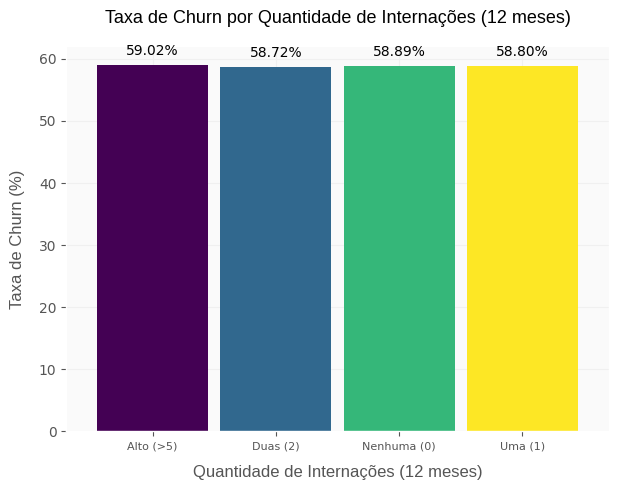

In [566]:
# Taxa Churn por Quantidade de Internações (12 meses)

# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(7, 5))

# Calcular os cancelamentos e o total de clientes por nova faixa de internacoes
cancelados_internacoes = cassi.groupby('Faixa_Internacoes')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_internacoes = cassi.groupby('Faixa_Internacoes').size()

# Calcular a taxa de churn por faixa de internacoes
taxa_churn_por_internacoes = (cancelados_internacoes) / (qtd_total_internacoes) * 100

# Definir as cores
colors = cmap(np.linspace(0, 1, len(taxa_churn_por_internacoes)))

# Visualizar com um gráfico
taxa_churn_por_internacoes.plot(kind='bar', color=colors, width=0.9, ax=ax)

# Ajustando título, rótulos e o eixo X
ax.set_title('Taxa de Churn por Quantidade de Internações (12 meses)', fontname='Liberation Sans', pad=17, size=13)
ax.set_xlabel('Quantidade de Internações (12 meses)', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=12, fontname='Liberation Sans', labelpad=10)

# Ajustar os rótulos do eixo X com base nas faixas
ax.set_xticklabels(taxa_churn_por_internacoes.index, rotation=0, fontsize=8)

# Adicionar as taxas de churn em cima das barras
ax.bar_label(ax.containers[0], labels=[f'{v:.2f}%' for v in taxa_churn_por_internacoes], fontsize=10, color='black', padding=5)

# Exibir o gráfico
plt.show()

###Sexo

In [567]:
#distribuição de SEXO:
distribuicao_sexo = cassi['SEXO'].value_counts()
print(distribuicao_sexo)

SEXO
F    50799
M    38204
Name: count, dtype: int64


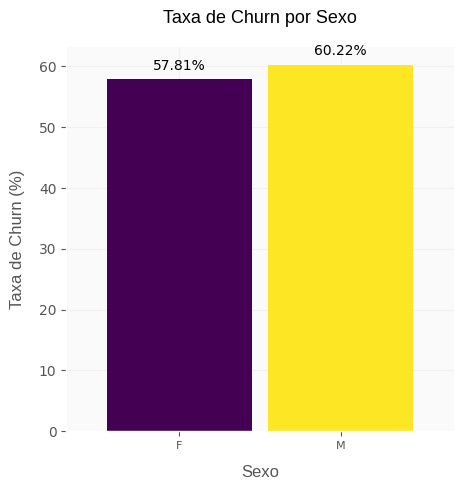

In [568]:
# Taxa Churn por Sexo

# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(5, 5))

# Calcular os cancelamentos e o total de clientes por sexo
cancelados_sexo = cassi.groupby('SEXO')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_sexo = cassi.groupby('SEXO').size()

# Calcular a taxa de churn por faixa de sexo
taxa_churn_por_sexo = (cancelados_sexo) / (qtd_total_sexo) * 100

# Definir as cores
colors = cmap(np.linspace(0, 1, len(taxa_churn_por_sexo)))

# Visualizar com um gráfico
taxa_churn_por_sexo.plot(kind='bar', color=colors, width=0.9, ax=ax)

# Ajustando título, rótulos e o eixo X
ax.set_title('Taxa de Churn por Sexo', fontname='Liberation Sans', pad=17, size=13)
ax.set_xlabel('Sexo', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=12, fontname='Liberation Sans', labelpad=10)

# Ajustar os rótulos do eixo X com base nas faixas
ax.set_xticklabels(taxa_churn_por_sexo.index, rotation=0, fontsize=8)

# Adicionar as taxas de churn em cima das barras
ax.bar_label(ax.containers[0], labels=[f'{v:.2f}%' for v in taxa_churn_por_sexo], fontsize=10, color='black', padding=5)

# Exibir o gráfico
plt.show()

###Inadimplência

In [569]:
#distribuição de INADIMPLENTES:
distribuicao_ina = cassi['INADIMPLENTE'].value_counts()
print(distribuicao_ina)

INADIMPLENTE
NÃO    65144
SIM    23859
Name: count, dtype: int64


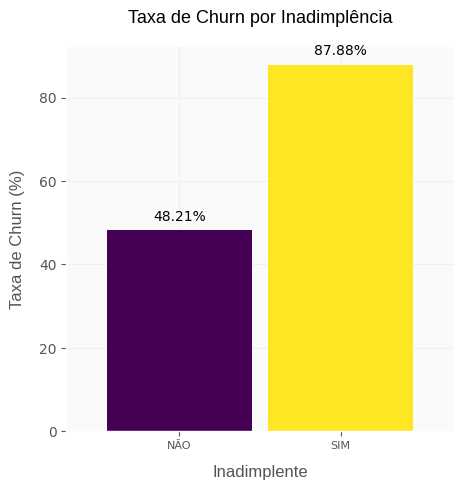

In [570]:
# Taxa Churn por Inadimplência

# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(5, 5))

# Calcular os cancelamentos e o total de clientes por ina
cancelados_ina = cassi.groupby('INADIMPLENTE')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_ina = cassi.groupby('INADIMPLENTE').size()

# Calcular a taxa de churn por faixa de ina
taxa_churn_por_ina = (cancelados_ina) / (qtd_total_ina) * 100

# Definir as cores
colors = cmap(np.linspace(0, 1, len(taxa_churn_por_ina)))

# Visualizar com um gráfico
taxa_churn_por_ina.plot(kind='bar', color=colors, width=0.9, ax=ax)

# Ajustando título, rótulos e o eixo X
ax.set_title('Taxa de Churn por Inadimplência', fontname='Liberation Sans', pad=17, size=13)
ax.set_xlabel('Inadimplente', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=12, fontname='Liberation Sans', labelpad=10)

# Ajustar os rótulos do eixo X com base nas faixas
ax.set_xticklabels(taxa_churn_por_ina.index, rotation=0, fontsize=8)

# Adicionar as taxas de churn em cima das barras
ax.bar_label(ax.containers[0], labels=[f'{v:.2f}%' for v in taxa_churn_por_ina], fontsize=10, color='black', padding=5)

# Exibir o gráfico
plt.show()

###Valor da Mensalidade

In [571]:
#distribuição de MENSALIDADES:
distribuicao_mensalidade = cassi['VALOR_MENSALIDADE'].value_counts()
print(distribuicao_mensalidade)

VALOR_MENSALIDADE
550.0     30143
1030.0    24295
720.0     17289
1360.0     9588
1870.0     7688
Name: count, dtype: int64


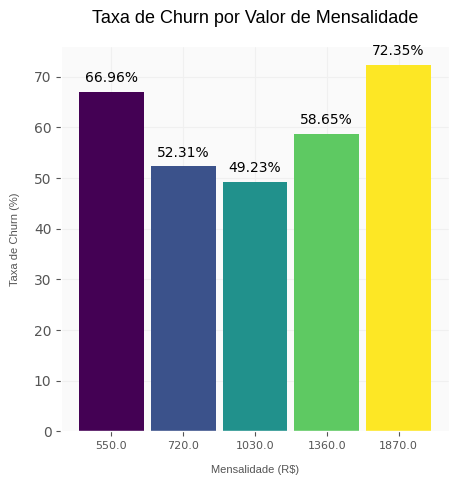

In [572]:
# Taxa Churn por Mensalidade

# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(5, 5))

# Calcular os cancelamentos e o total de clientes por mensalidade
cancelados_mensalidade = cassi.groupby('VALOR_MENSALIDADE')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_mensalidade = cassi.groupby('VALOR_MENSALIDADE').size()

# Calcular a taxa de churn por faixa de ina
taxa_churn_por_mensalidade = (cancelados_mensalidade) / (qtd_total_mensalidade) * 100

# Definir as cores
colors = cmap(np.linspace(0, 1, len(taxa_churn_por_mensalidade)))

# Visualizar com um gráfico
taxa_churn_por_mensalidade.plot(kind='bar', color=colors, width=0.9, ax=ax)

# Ajustando título, rótulos e o eixo X
ax.set_title('Taxa de Churn por Valor de Mensalidade', fontname='Liberation Sans', pad=17, size=13)
ax.set_xlabel('Mensalidade (R$)', fontsize=8, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=8, fontname='Liberation Sans', labelpad=10)

# Ajustar os rótulos do eixo X com base nas faixas
ax.set_xticklabels(taxa_churn_por_mensalidade.index, rotation=0, fontsize=8)

# Adicionar as taxas de churn em cima das barras
ax.bar_label(ax.containers[0], labels=[f'{v:.2f}%' for v in taxa_churn_por_mensalidade], fontsize=10, color='black', padding=5)

# Exibir o gráfico
plt.show()

###UF

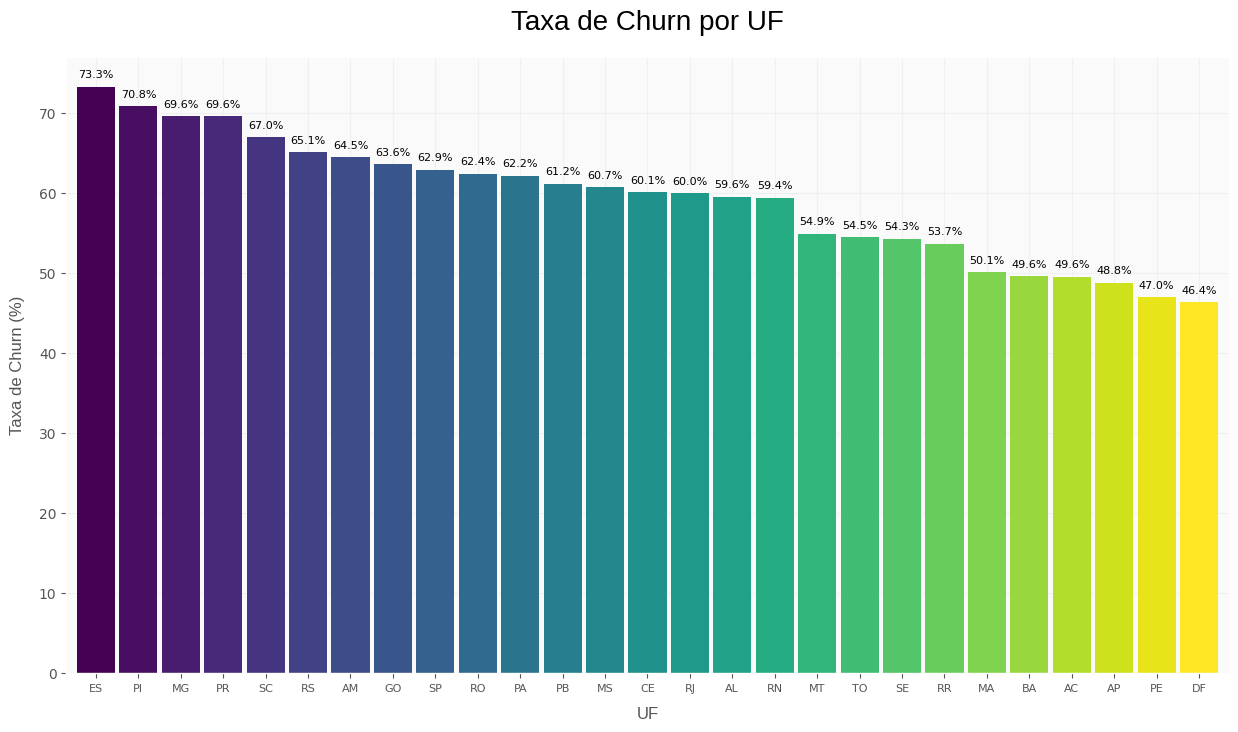

In [573]:
# Taxa Churn por UF
# Carrega folha de estilo
plt.style.use("ggplot")

# Modifica mais alguns parâmetros
plt.rc("axes", facecolor="#fafafa", grid=True)  # Cor do fundo
plt.rc("grid", color="#f0f0f0")  # Cor do quadriculado

cmap = plt.cm.viridis
fig, ax = plt.subplots(figsize=(15, 8))

# Calcular os cancelamentos e o total de clientes por UF
cancelados_uf = cassi.groupby('UF')['CANCELADO'].apply(lambda x: (x == 'SIM').sum())
qtd_total_uf = cassi.groupby('UF').size()

# Calcular a taxa de churn por UF
taxa_churn_por_uf = (cancelados_uf) / (qtd_total_uf) * 100

# Ordenar as taxas de churn por UF do maior para o menor
taxa_churn_por_uf = taxa_churn_por_uf.sort_values(ascending=False)

# Definir as cores
colors = cmap(np.linspace(0, 1, len(taxa_churn_por_uf)))

# Visualizar com um gráfico
taxa_churn_por_uf.plot(kind='bar', color=colors, width=0.9, ax=ax)

# Ajustando título, rótulos e o eixo X
ax.set_title('Taxa de Churn por UF', fontname='Liberation Sans', pad=20, size=20)
ax.set_xlabel('UF', fontsize=12, fontname='Liberation Sans', labelpad=10)
ax.set_ylabel('Taxa de Churn (%)', fontsize=12, fontname='Liberation Sans', labelpad=10)

# Ajustar os rótulos do eixo X com base nas faixas
ax.set_xticklabels(taxa_churn_por_uf.index, rotation=0, fontsize=8)

# Adicionar as taxas de churn em cima das barras
ax.bar_label(ax.containers[0], labels=[f'{v:.1f}%' for v in taxa_churn_por_uf], fontsize=8, color='black', padding=5)

# Exibir o gráfico
plt.show()


##Análise de relevância das variáveis

Agora que comparamos as taxas de churn dentro dos grupos, vamos entender melhor a correlação entre as variáveis.

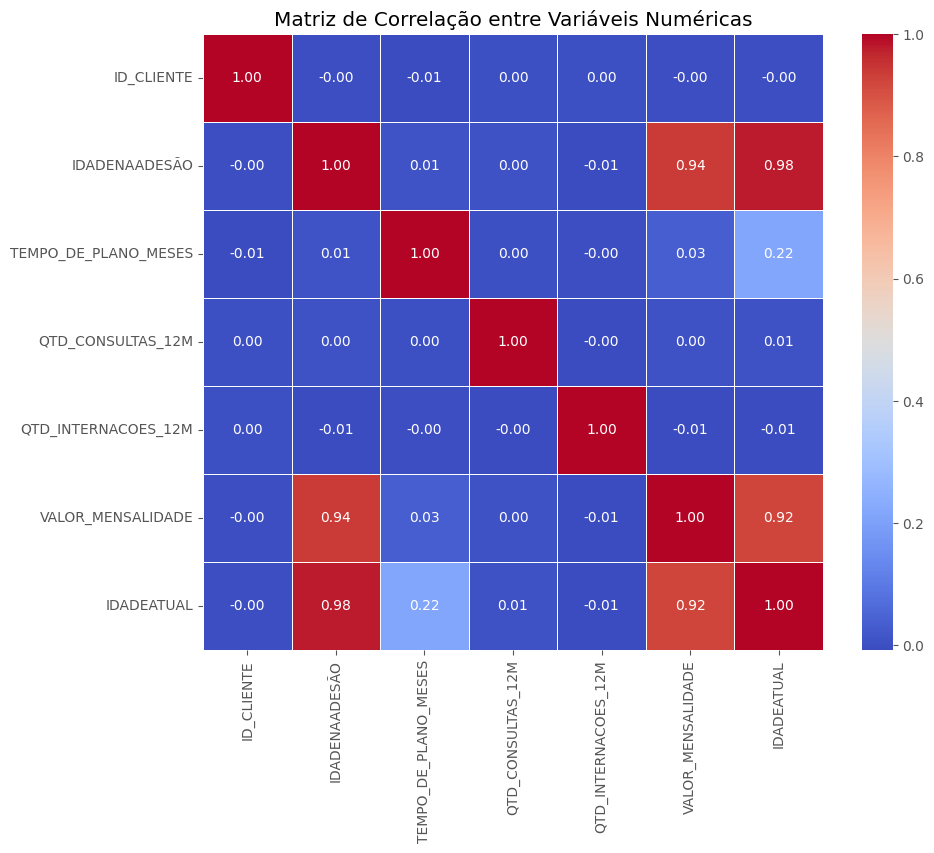

In [574]:
# Matriz de correlação
correlacao = cassi.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacao, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

Através da matriz de correlação, notamos que:

*   `IDADADEATUAL` e `IDADENAADESÃO` tem correlação positiva forte, o que faz sentido pois é função da outra;


*   `VALOR_MENSALIDADE` e `IDADENAADESÃO` tem correlação positiva forte, o que pode indicar que dependendo de qual idade a pessoa inicia o contrato do plano, os valores podem diferir de alguém que tem a mesma idade e tem o plano há mais tempo.

*   `QTD_CONSULTAS_12M` e `QTD_INTERNACOES_12M`: tem uma correlação baixa, o que sugere que os númeres de consultas não tem relação direta com o número de internações

Dadas essas observações, podemos:

*   Considerar apenas uma das variáveis (já tínhamos chegado à essa conclusão em seções anteriores) entre `IDADADEATUAL` e `IDADENAADESÃO`.
*   Considerando a seleção de variáveis, podemos notar que, dado o noxxo contexto de taxa de churn, as variáveis `VALOR_MENSALIDADE` e `IDADENAADESÃO` tem relevância teórica, então possivelmente vamos utilizá-las.

Agora vamos definit a **importância das variáveis** para algoritmo Random Forest:

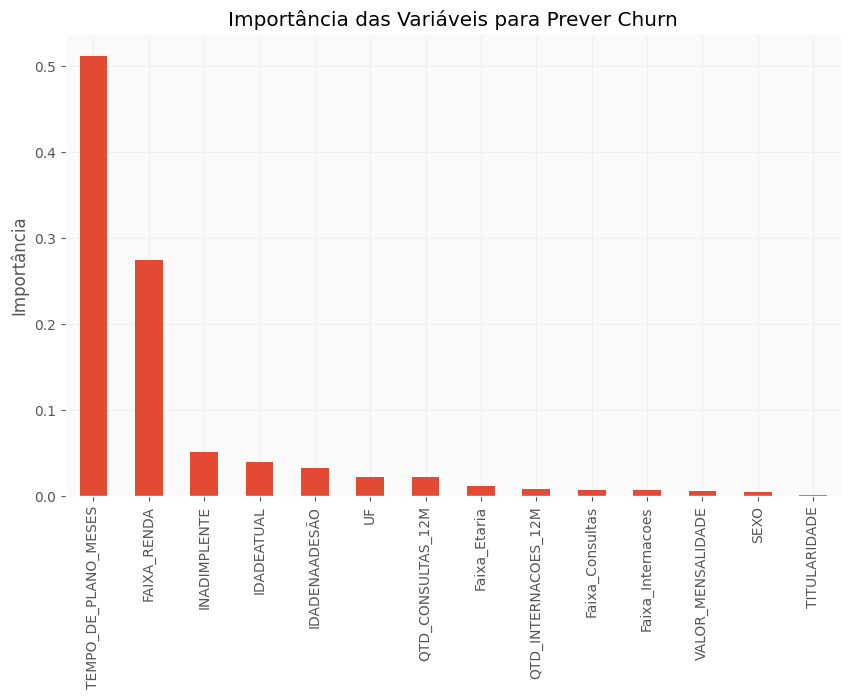

TEMPO_DE_PLANO_MESES    0.511832
FAIXA_RENDA             0.274025
INADIMPLENTE            0.051061
IDADEATUAL              0.039363
IDADENAADESÃO           0.032834
dtype: float64


In [575]:
from sklearn.preprocessing import LabelEncoder

# Definindo o LabelEncoder
le = LabelEncoder()

# Aplicando Label Encoding nas variáveis categóricas
cassi['SEXO'] = le.fit_transform(cassi['SEXO'])
cassi['FAIXA_RENDA'] = le.fit_transform(cassi['FAIXA_RENDA'])
cassi['UF'] = le.fit_transform(cassi['UF'])
cassi['INADIMPLENTE'] = le.fit_transform(cassi['INADIMPLENTE'])
cassi['TITULARIDADE'] = le.fit_transform(cassi['TITULARIDADE'])
cassi['Faixa_Etaria'] = le.fit_transform(cassi['Faixa_Etaria'])
cassi['Faixa_Consultas'] = le.fit_transform(cassi['Faixa_Consultas'])
cassi['Faixa_Internacoes'] = le.fit_transform(cassi['Faixa_Internacoes'])

# Excluindo 'ID_CLIENTE' e 'CANCELADO' das variáveis independentes
X = cassi.drop(columns=['CANCELADO', 'ID_CLIENTE', 'Faixa_Consultas_Nova'])
y = cassi['CANCELADO'].apply(lambda x: 1 if x == 'SIM' else 0)  # Convertendo para binário

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar o modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o modelo
rf.fit(X_train, y_train)

# Obter a importância das variáveis
importancia = pd.Series(rf.feature_importances_, index=X.columns)
importancia = importancia.sort_values(ascending=False)

# Visualizar a importância das variáveis
plt.figure(figsize=(10, 6))
importancia.plot(kind='bar')
plt.title('Importância das Variáveis para Prever Churn')
plt.ylabel('Importância')
plt.show()

# Exibir as 5 variáveis mais importantes
print(importancia.head())


Através do Gráfico de Importâncias das variáveis, notamos que:

*   `TEMPO_DE_PLANO_MESES` é a variável mais importante para prever o churn, com uma importância de aproximadamente 0.5.
*   `FAIXA_RENDA` é a segunda variável mais importante, com uma importância de cerca de 0.3.
*   As variáveis como `SEXO` e `UF` têm uma importância muito baixa, sugerindo que esses fatores não contribuem significativamente para o modelo, ou a relação deles com o churn não é tão forte.

O modelo está identificando que **quanto mais tempo o cliente permanece no plano**, maior a probabilidade de ele ter churn, talvez por uma relação de insatisfação com o tempo de uso.

A **faixa de renda** também parece ser um fator importante, possivelmente porque diferentes grupos de renda podem ter comportamentos distintos em relação ao churn.

#Aprendizado de Máquina para prever a taxa de Churn

##Modelo 1 - Random Forest

Primeiro vamos considerar o algoritmo Random Florest com as variáveis explicativas `TEMPO_DE_PLANO_MESES` e `FAIXA_RENDA`:

Relatório de Avaliação:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10922
           1       0.95      0.96      0.95     15779

    accuracy                           0.95     26701
   macro avg       0.95      0.94      0.94     26701
weighted avg       0.95      0.95      0.95     26701

Matriz de Confusão:
[[10108   814]
 [  627 15152]]


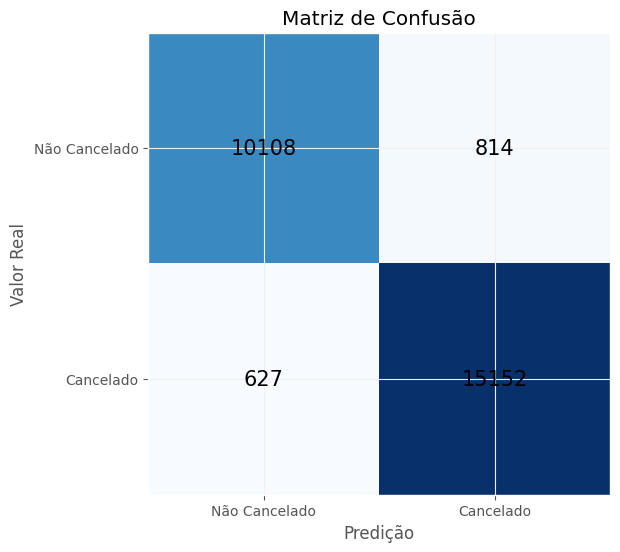

In [576]:
# Usando Label Encoding para as variáveis categóricas
from sklearn.preprocessing import LabelEncoder

# Inicializando o LabelEncoder
# Inicializando o LabelEncoder
le = LabelEncoder()

# Codificando a variável 'FAIXA_RENDA'
cassi['FAIXA_RENDA'] = le.fit_transform(cassi['FAIXA_RENDA'])

# Selecionando apenas 'TEMPO_DE_PLANO_MESES' e 'FAIXA_RENDA' como variáveis explicativas
X = cassi[['TEMPO_DE_PLANO_MESES', 'FAIXA_RENDA']]

# Convertendo 'CANCELADO' para valores binários (1 para SIM, 0 para NÃO)
y = cassi['CANCELADO'].apply(lambda x: 1 if x == 'SIM' else 0)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criando o modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Predições do modelo
y_pred = rf.predict(X_test)

# Gerar o relatório de avaliação
report = classification_report(y_test, y_pred)
print("Relatório de Avaliação:")
print(report)

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Plotando a Matriz de Confusão
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(conf_matrix, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Não Cancelado', 'Cancelado'])
ax.set_yticklabels(['Não Cancelado', 'Cancelado'])

for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black', fontsize=15)

plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.show()

Nesse caso, como queremos capturar tanto clientes que vão cancelar (o melhor possível) como minimizar os clientes classificados como "CANCELADOS", porém com uma predição errada.

F1-Score modelo 1:



In [577]:
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.4f}')
precision = precision_score(y_test, y_pred)
print(f"Precisão: {precision:.4f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

F1-Score: 0.9546
Precisão: 0.9490
Recall: 0.9603


In [578]:
# F1-score no treinamento (para os dados de treino)
y_train_pred = rf.predict(X_train)  # Predição no conjunto de treino
f1_train = f1_score(y_train, y_train_pred)
print(f"F1-Score no Treinamento: {f1_train:.4f}")

# F1-score no teste (para os dados de teste)
f1_test = f1_score(y_test, y_pred)  # y_pred já foi calculado
print(f"F1-Score no Teste: {f1_test:.4f}")

F1-Score no Treinamento: 0.9554
F1-Score no Teste: 0.9546


Curva AUC-ROC:

A AUC próxima de 1 indica um modelo bom, enquanto valores mais próximos de 0.5 indicam que o modelo está aleatório.

AUC-ROC: 0.9926


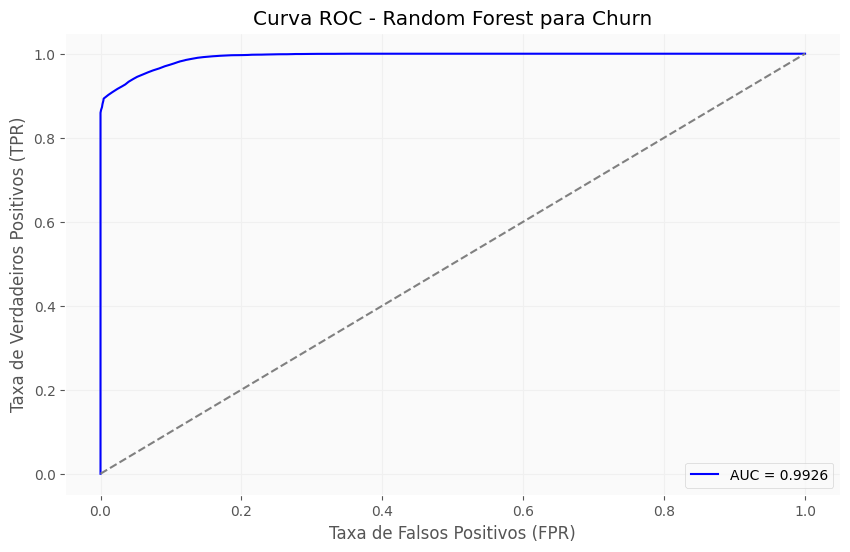

In [579]:
from sklearn.metrics import roc_auc_score, roc_curve
# Predições de probabilidade para a classe positiva (churn)
y_pred_proba = rf.predict_proba(X_test)[:, 1]  # Probabilidade da classe '1' (churn)

# Calcular a AUC-ROC
auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc:.4f}')

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plotar a curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Linha de chance aleatória
plt.title('Curva ROC - Random Forest para Churn')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend(loc='lower right')
plt.show()

Esse modelo apresenta boas métricas, porém temos que tomar cuidado com overfitting. Vamos normalizar os dados para entender se isso melhora um pouco mais as predições:

Relatório de Avaliação:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     10922
           1       0.95      0.96      0.95     15779

    accuracy                           0.95     26701
   macro avg       0.95      0.94      0.94     26701
weighted avg       0.95      0.95      0.95     26701

Matriz de Confusão:
[[10108   814]
 [  627 15152]]


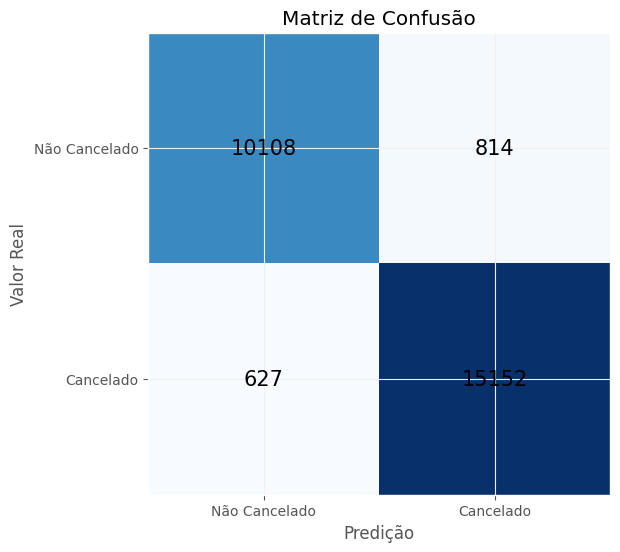

In [580]:


# Inicializando o LabelEncoder
le = LabelEncoder()

# Codificando a variável 'FAIXA_RENDA'
cassi['FAIXA_RENDA'] = le.fit_transform(cassi['FAIXA_RENDA'])

# Selecionando apenas 'TEMPO_DE_PLANO_MESES' e 'FAIXA_RENDA' como variáveis explicativas
X = cassi[['TEMPO_DE_PLANO_MESES', 'FAIXA_RENDA']]

# Convertendo 'CANCELADO' para valores binários (1 para SIM, 0 para NÃO)
y = cassi['CANCELADO'].apply(lambda x: 1 if x == 'SIM' else 0)

# Normalizar os dados com StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Criando o modelo de Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
rf.fit(X_train, y_train)

# Predições do modelo
y_pred = rf.predict(X_test)

# Gerar o relatório de avaliação
report = classification_report(y_test, y_pred)
print("Relatório de Avaliação:")
print(report)

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Plotando a Matriz de Confusão
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(conf_matrix, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Não Cancelado', 'Cancelado'])
ax.set_yticklabels(['Não Cancelado', 'Cancelado'])

for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black', fontsize=15)

plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.show()


In [581]:
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.4f}')
precision = precision_score(y_test, y_pred)
print(f"Precisão: {precision:.4f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

F1-Score: 0.9546
Precisão: 0.9490
Recall: 0.9603


In [582]:
# F1-score no treinamento (para os dados de treino)
y_train_pred = rf.predict(X_train)  # Predição no conjunto de treino
f1_train = f1_score(y_train, y_train_pred)
print(f"F1-Score no Treinamento: {f1_train:.4f}")

# F1-score no teste (para os dados de teste)
f1_test = f1_score(y_test, y_pred)  # y_pred já foi calculado
print(f"F1-Score no Teste: {f1_test:.4f}")

F1-Score no Treinamento: 0.9554
F1-Score no Teste: 0.9546


Agora vamos adicionar algumas outras variáveis que podem fazer sentido no contexto de Taxa de Churn: `VALOR_MENSALIDADE` e `Faixa_Etária`.





Relatório de Avaliação:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10922
           1       0.95      0.96      0.95     15779

    accuracy                           0.95     26701
   macro avg       0.95      0.94      0.94     26701
weighted avg       0.95      0.95      0.95     26701

Matriz de Confusão:
[[10065   857]
 [  596 15183]]


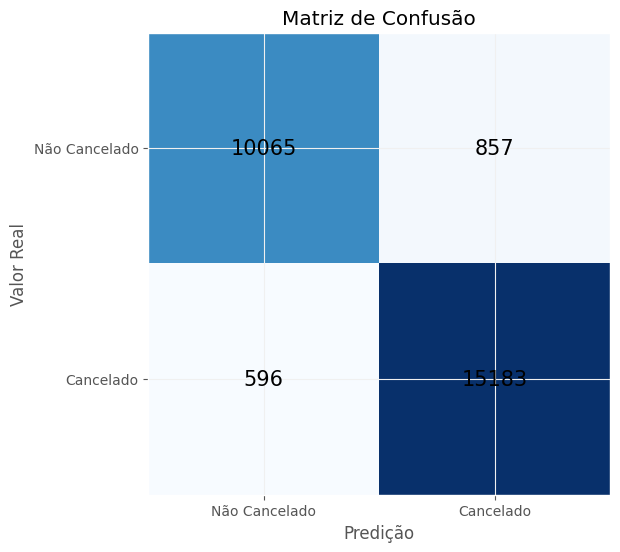

In [583]:

# Inicializando o LabelEncoder
le = LabelEncoder()

# Codificando a variável 'FAIXA_RENDA'
cassi['FAIXA_RENDA'] = le.fit_transform(cassi['FAIXA_RENDA'])
cassi['Faixa_Etaria'] = le.fit_transform(cassi['Faixa_Etaria'])

# Selecionando agora 'TEMPO_DE_PLANO_MESES', 'FAIXA_RENDA', 'VALOR_MENSALIDADE' e 'IDADEATUAL' como variáveis explicativas
X = cassi[['TEMPO_DE_PLANO_MESES', 'FAIXA_RENDA', 'VALOR_MENSALIDADE', 'Faixa_Etaria']]

# Convertendo 'CANCELADO' para valores binários (1 para SIM, 0 para NÃO)
y = cassi['CANCELADO'].apply(lambda x: 1 if x == 'SIM' else 0)

# Normalizar os dados com StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Criando o modelo de Random Forest
rf_churn = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
rf_churn.fit(X_train, y_train)

# Predições do modelo
y_pred = rf_churn.predict(X_test)

# Gerar o relatório de avaliação
report = classification_report(y_test, y_pred)
print("Relatório de Avaliação:")
print(report)

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Plotando a Matriz de Confusão
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(conf_matrix, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Não Cancelado', 'Cancelado'])
ax.set_yticklabels(['Não Cancelado', 'Cancelado'])

for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black', fontsize=15)

plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.show()


In [584]:
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.4f}')
precision = precision_score(y_test, y_pred)
print(f"Precisão: {precision:.4f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

F1-Score: 0.9543
Precisão: 0.9466
Recall: 0.9622


##Modelo 2 - Naive Bayes

Relatório de Avaliação:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93     10922
           1       0.98      0.91      0.95     15779

    accuracy                           0.94     26701
   macro avg       0.93      0.94      0.94     26701
weighted avg       0.94      0.94      0.94     26701

Matriz de Confusão:
[[10647   275]
 [ 1396 14383]]


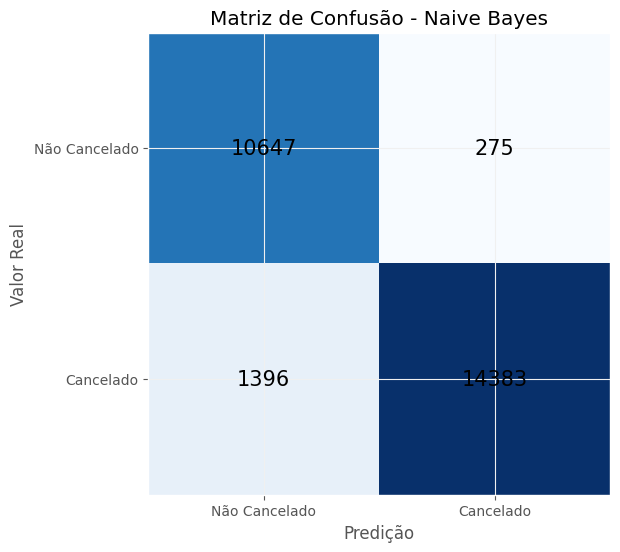

In [585]:
# Inicializando o LabelEncoder
le = LabelEncoder()

# Codificando a variável 'FAIXA_RENDA'
cassi['FAIXA_RENDA'] = le.fit_transform(cassi['FAIXA_RENDA'])

# Selecionando as variáveis explicativas
X = cassi[['TEMPO_DE_PLANO_MESES', 'FAIXA_RENDA']]

# Convertendo 'CANCELADO' para valores binários (1 para SIM, 0 para NÃO)
y = cassi['CANCELADO'].apply(lambda x: 1 if x == 'SIM' else 0)

# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Criando o modelo de Naive Bayes (Gaussian Naive Bayes para dados contínuos)
nb = GaussianNB()

# Treinando o modelo
nb.fit(X_train, y_train)

# Predições do modelo
y_pred = nb.predict(X_test)

# Gerar o relatório de avaliação
report = classification_report(y_test, y_pred)
print("Relatório de Avaliação:")
print(report)

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Plotando a Matriz de Confusão
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(conf_matrix, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Não Cancelado', 'Cancelado'])
ax.set_yticklabels(['Não Cancelado', 'Cancelado'])

for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black', fontsize=15)

plt.title('Matriz de Confusão - Naive Bayes')
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.show()

In [586]:
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.4f}')
precision = precision_score(y_test, y_pred)
print(f"Precisão: {precision:.4f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

F1-Score: 0.9451
Precisão: 0.9812
Recall: 0.9115


In [587]:
# F1-score no treinamento (para os dados de treino)
y_train_pred = rf.predict(X_train)  # Predição no conjunto de treino
f1_train = f1_score(y_train, y_train_pred)
print(f"F1-Score no Treinamento: {f1_train:.4f}")

# F1-score no teste (para os dados de teste)
f1_test = f1_score(y_test, y_pred)  # y_pred já foi calculado
print(f"F1-Score no Teste: {f1_test:.4f}")

F1-Score no Treinamento: 0.9554
F1-Score no Teste: 0.9451


## Modelo 3 - SVM

SMV é uma algoritmo que funciona bem com grandes volumes de dados, apesar de ser um pouco mais lento. Além disso, é necessário normalizar os dados.

Relatório de Avaliação:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10922
           1       0.95      0.96      0.95     15779

    accuracy                           0.94     26701
   macro avg       0.94      0.94      0.94     26701
weighted avg       0.94      0.94      0.94     26701

Matriz de Confusão:
[[10122   800]
 [  706 15073]]


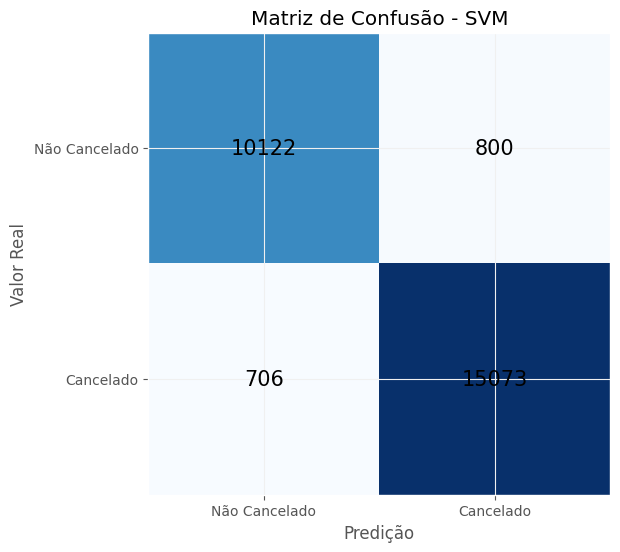

In [588]:
from sklearn.svm import SVC


# Inicializando o LabelEncoder
le = LabelEncoder()

# Codificando a variável 'FAIXA_RENDA'
cassi['FAIXA_RENDA'] = le.fit_transform(cassi['FAIXA_RENDA'])

# Selecionando as variáveis explicativas
X = cassi[['TEMPO_DE_PLANO_MESES', 'FAIXA_RENDA']]

# Convertendo 'CANCELADO' para valores binários (1 para SIM, 0 para NÃO)
y = cassi['CANCELADO'].apply(lambda x: 1 if x == 'SIM' else 0)

# Normalizar os dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

# Criando o modelo SVM com kernel RBF
svm = SVC(kernel='rbf', random_state=42)

# Treinando o modelo
svm.fit(X_train, y_train)

# Predições do modelo
y_pred = svm.predict(X_test)

# Gerar o relatório de avaliação
report = classification_report(y_test, y_pred)
print("Relatório de Avaliação:")
print(report)

# Gerar a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Plotando a Matriz de Confusão
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(conf_matrix, cmap='Blues')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Não Cancelado', 'Cancelado'])
ax.set_yticklabels(['Não Cancelado', 'Cancelado'])

for i in range(2):
    for j in range(2):
        ax.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black', fontsize=15)

plt.title('Matriz de Confusão - SVM')
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.show()


In [589]:
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.4f}')
precision = precision_score(y_test, y_pred)
print(f"Precisão: {precision:.4f}")
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

F1-Score: 0.9524
Precisão: 0.9496
Recall: 0.9553


In [590]:
# F1-score no treinamento (para os dados de treino)
y_train_pred = rf.predict(X_train)  # Predição no conjunto de treino
f1_train = f1_score(y_train, y_train_pred)
print(f"F1-Score no Treinamento: {f1_train:.4f}")

# F1-score no teste (para os dados de teste)
f1_test = f1_score(y_test, y_pred)  # y_pred já foi calculado
print(f"F1-Score no Teste: {f1_test:.4f}")

F1-Score no Treinamento: 0.9554
F1-Score no Teste: 0.9524


#Conclusão

**F1-Score:** Essa métrica é a média harmônica entre precisão e recall, oferecendo um equilíbrio entre as duas. É especialmente útil quando temos uma distribuição desigual de classes (como no caso de churn, onde as classes "Cancelado" e "Não Cancelado" podem ser desbalanceadas).

**Precisão:** Indica a proporção de previsões positivas corretas em relação ao total de previsões positivas feitas pelo modelo.

**Recall:** Mede a proporção de reais positivos que foram corretamente identificados pelo modelo.

**Comparação entre os modelos:**

*   Random Forest:

O Random Forest tem o F1-Score mais alto de 0.9546, o que indica um bom equilíbrio entre precisão e recall. O recall de 0.9603 é bastante alto, significando que o modelo consegue identificar a maior parte dos clientes que cancelam. A precisão também é boa (0.9490), mas não é a melhor.

*   Naive Bayes:

O Naive Bayes tem a precisão mais alta (0.9807), o que significa que ele faz menos previsões falsas positivas. No entanto, o recall (0.9136) é o mais baixo entre os modelos, indicando que ele está perdendo uma quantidade considerável de clientes que realmente cancelaram (falsos negativos). Isso pode ser um problema, já que perder clientes cancelados é mais crítico do que errar previsões de clientes que não cancelam.

*   SVM:

O SVM tem o F1-Score de 0.9534, que é muito próximo ao do Random Forest. Ele também apresenta um bom recall de 0.9559, e uma precisão de 0.9509, que é bastante equilibrada.

Portanto, após a análise dos três modelos acima, vamos usar o que utiliza **Random Forest** com quartro variáveis explicativas.

O modelo escolhido (abaixo) apresenta o melhor equilíbrio entre precisão e recall, com um F1-Score mais alto do que os outros modelos. Além disso, tem uma taxa de recall muito alta, o que é importante no caso de previsão de churn, já que você quer minimizar a quantidade de clientes que cancelam e não são identificados pelo modelo.

Embora o modelo que utiliza **Naive Bayes** tenha uma precisão maior, a baixa taxa de recall é preocupante, pois ele perde clientes que realmente cancelam (FN).



Portanto, o modelo **rf_churn** é a melhor opção capaz de estimar quais beneficiários têm maior risco de evasão nos próximos 12 meses (ou seja, os planos cancelados).

Além isso, apesar de termos usado 4 variáveis explicativas, vimos que duas delas tem um peso grande na explicação da variável "CANCELADO": TEMPO_DE_PLANO_MESES', 'FAIXA_RENDA'.

Vimos anteriormente que quanto maior o tempo de plano, maior a tendência ao churn, ou seja, faz sentido tentar entender por que as pessoas costumam ficar insatisfeitas a medida que o tempo passa. Seria porque outros planos são mais atrativos no sentido de atualização de profissionais/hospitais? Talvez faça sentido implementar ações para tentar recuperar essa parcela possivelmente insatisfeita da população. Uma outra possível ideia é rodas pesquisas de satisfação com brindes em troca da participação.

Outro fator importante na taxa de Churn é a Faixa de Renda, sendo que a renda mais baixa tem uma porcentagem maior de Churn quando analisamos os dados do banco disponível. É possível que a os reajustes de mensalidade de tempos em tempos estejam fazendo com que o pagamento mensal se torne difícil (esses ajustes acompanham os ajustes de salário mínimo?). Será que faria sentido a criação de mais uma categoria de plano para pessoas de rendas mais baixas? Quais seriam as opções que tornariam isso viável?

Observações: Não tive muito tempo de testar outros modelos e parâmetros, mas seria interessante fazê-lo num contexto de mais tempo e mais entendimento do cenário.